In [4]:
# Block 1: Import Libraries and Environment Setup
import os
import sys
import subprocess
import importlib.util
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import resnet18, resnet50
import torchvision.models.segmentation as segmentation
from torch.autograd import Variable
from sklearn.metrics import jaccard_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Print confirmation
print("✓ Block 1 executed successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

✓ Block 1 executed successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU Device: Tesla T4


In [5]:
import torch
from torch import nn
#%pip install install graphviz
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-w7j6emz2
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-w7j6emz2
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=a8eb86243b71eaeb03fdb470bc19f2e7ed23270cbac895ffe4eb992c817ebee7
  Stored in directory: /tmp/pip-ephem-wheel-cache-x81i24c4/wheels/25/56/a1/1f720f17e33829c5560516085bf3fbae7bb839f1195c674b99
Successfully built torchviz
  Attempting uninstall: torchviz
    Found existing installation: torchviz 0.0.3
    Uninstalling torchviz-0.0.3:
      Successfully uninstalled torchviz-0.0.3
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Block 2: GPU Memory Management and Device Setup

# Configure GPU memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear GPU cache if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Additional GPU settings for better memory management
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# Print GPU memory status
if torch.cuda.is_available():
    print(f"✓ Block 2 executed successfully!")
    print(f"Device set to: {device}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    print(f"GPU Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB")
else:
    print("✓ Block 2 executed successfully!")
    print(f"Device set to: {device} (CPU mode)")

✓ Block 2 executed successfully!
Device set to: cuda
GPU Memory Allocated: 0.00 MB
GPU Memory Cached: 0.00 MB
GPU Total Memory: 15095.06 MB


In [7]:
# Block 3: Load Color Mapping and Dataset Information

def load_color_mapping(csv_path):
    """
    Load the CSV file containing color mappings for each class
    Returns: color_mapping dict and dataframe
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)
    # Create a mapping from (r, g, b) to the class index
    color_mapping = {(row['r'], row['g'], row['b']): idx for idx, row in df.iterrows()}
    return color_mapping, df

# Load color mapping
color_mapping, df = load_color_mapping("/kaggle/input/camvid/CamVid/class_dict.csv")

# Print dataset information
print("✓ Block 3 executed successfully!")
print(f"Number of classes: {len(color_mapping)}")
print(f"Classes loaded: {len(df)} classes")
print("\nFirst 5 classes:")
print(df.head())
print(f"\nTotal unique colors in mapping: {len(color_mapping)}")

# Store class names for later use
class_names = df['name'].tolist() if 'name' in df.columns else [f'Class_{i}' for i in range(len(df))]
num_classes = len(class_names)
print(f"\nClass names stored: {num_classes} classes")

✓ Block 3 executed successfully!
Number of classes: 32
Classes loaded: 32 classes

First 5 classes:
        name    r    g    b
0     Animal   64  128   64
1    Archway  192    0  128
2  Bicyclist    0  128  192
3     Bridge    0  128   64
4   Building  128    0    0

Total unique colors in mapping: 32

Class names stored: 32 classes


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class CamVidDataset(Dataset):
    """
    Custom Dataset class for CamVid semantic segmentation
    Handles image loading, label conversion, and transformations
    """
    def __init__(self, image_dir, label_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.color_mapping = color_mapping
        self.transform = transform
        self.image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)
                                 if f.endswith('.png') or f.endswith('.jpg')])
        self.label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)
                                 if f.endswith('.png')])

        # Validate dataset
        assert len(self.image_files) == len(self.label_files), \
            f"Mismatch: {len(self.image_files)} images vs {len(self.label_files)} labels"

        # Initialize class distribution tracking
        self.class_pixel_counts = None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and label
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        label = cv2.imread(self.label_files[idx])
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        # Convert RGB label to class indices
        label = self.convert_rgb_to_class(label)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        # Ensure types are correct
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()

        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label).long()  # ✅ Ensures LongTensor for one_hot()

        return image, label

    def convert_rgb_to_class(self, label):
        """Convert RGB mask to class indices."""
        # Create an empty mask with the same shape as the label
        class_mask = np.zeros((label.shape[0], label.shape[1]), dtype=np.int64)

        # Iterate over each pixel and assign the class index based on RGB value
        for rgb, class_idx in self.color_mapping.items():
            mask = (label[:, :, 0] == rgb[0]) & (label[:, :, 1] == rgb[1]) & (label[:, :, 2] == rgb[2])
            class_mask[mask] = class_idx

        return class_mask

    def compute_class_distribution(self, sample_size=None):
        """Compute pixel-wise class distribution across dataset"""
        if self.class_pixel_counts is not None:
            return self.class_pixel_counts

        class_counts = np.zeros(len(self.color_mapping))
        total_pixels = 0

        # Use subset if sample_size specified
        indices = range(len(self)) if sample_size is None else range(min(sample_size, len(self)))

        print(f"Computing class distribution for {len(indices)} images...")
        for idx in indices:
            label = cv2.imread(self.label_files[idx])
            label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
            label = self.convert_rgb_to_class(label)

            # Count pixels per class
            unique, counts = np.unique(label, return_counts=True)
            for cls_idx, count in zip(unique, counts):
                class_counts[cls_idx] += count
            total_pixels += label.size

        self.class_pixel_counts = class_counts
        self.total_pixels = total_pixels
        return class_counts

print("✓ Block 4 executed successfully!")
print("CamVidDataset class created with:")
print("  - Image and label loading")
print("  - RGB to class index conversion")
print("  - Transformation support")
print("  - Class distribution computation")

✓ Block 4 executed successfully!
CamVidDataset class created with:
  - Image and label loading
  - RGB to class index conversion
  - Transformation support
  - Class distribution computation


In [ ]:
# Block 5: Data Augmentation Pipelines

def get_transforms(train=True):
    """
    Get augmentation transforms for training or validation/test
    Enhanced with more augmentation options for better generalization
    """
    if train:
        return A.Compose([
            # Spatial transforms
            A.Resize(400, 520),
            A.RandomCrop(height=352, width=480),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),

            # Pixel-level transforms
            A.GaussianBlur(blur_limit=(3, 5), p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            A.RandomBrightnessContrast(p=0.3),
            A.RandomGamma(p=0.2),

            # Weather augmentations for robustness
            A.RandomSunFlare(p=0.1, src_radius=100),
            A.RandomShadow(p=0.2),

            # Normalization (CamVid dataset statistics)
            A.Normalize(mean=(0.390, 0.405, 0.414),
                       std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(352, 480),
            A.Normalize(mean=(0.390, 0.405, 0.414),
                       std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])

# Create augmentation pipelines
train_transform = get_transforms(train=True)
val_transform = get_transforms(train=False)

print("✓ Block 5 executed successfully!")
print("Data augmentation pipelines created:")
print("  - Training: Resize, RandomCrop, Flip, Rotate, Blur, ColorJitter, Weather effects")
print("  - Validation/Test: Resize and Normalize only")
print(f"  - Output size: 352x480 pixels")
print(f"  - Normalization: mean={train_transform.transforms[-2].mean}, std={train_transform.transforms[-2].std}")

✓ Block 5 executed successfully!
Data augmentation pipelines created:
  - Training: Resize, RandomCrop, Flip, Rotate, Blur, ColorJitter, Weather effects
  - Validation/Test: Resize and Normalize only
  - Output size: 352x480 pixels
  - Normalization: mean=(0.39, 0.405, 0.414), std=(0.274, 0.285, 0.297)


In [ ]:
# Block 6: Load Datasets and Analyze Class Distribution

# Instantiate datasets with the color map
train_dataset = CamVidDataset('/kaggle/input/camvid/CamVid/train',
                             '/kaggle/input/camvid/CamVid/train_labels',
                             color_mapping,
                             transform=train_transform)

val_dataset = CamVidDataset('/kaggle/input/camvid/CamVid/val',
                           '/kaggle/input/camvid/CamVid/val_labels',
                           color_mapping,
                           transform=val_transform)

test_dataset = CamVidDataset('/kaggle/input/camvid/CamVid/test',
                            '/kaggle/input/camvid/CamVid/test_labels',
                            color_mapping,
                            transform=val_transform)

# Print dataset sizes
print("✓ Block 6 executed successfully!")
print(f"Dataset sizes:")
print(f"  - Training: {len(train_dataset)} images")
print(f"  - Validation: {len(val_dataset)} images")
print(f"  - Testing: {len(test_dataset)} images")
print(f"  - Total: {len(train_dataset) + len(val_dataset) + len(test_dataset)} images")

# Compute class distribution on a sample of training data
print("\nComputing class distribution on training set (this may take a moment)...")
class_distribution = train_dataset.compute_class_distribution(sample_size=50)

# Calculate class weights for handling imbalance
total_pixels = class_distribution.sum()
class_frequencies = class_distribution / total_pixels
class_weights = 1.0 / (class_frequencies + 1e-6)  # Add small epsilon to avoid division by zero
class_weights = class_weights / class_weights.mean()  # Normalize weights

# Save class distribution to file
os.makedirs('results', exist_ok=True)
with open('results/class_distribution.txt', 'w') as f:
    f.write("CamVid Dataset Class Distribution Analysis\n")
    f.write("==========================================\n\n")
    f.write(f"Total pixels analyzed: {total_pixels:,}\n\n")
    f.write("Class-wise pixel distribution:\n")
    f.write("-" * 50 + "\n")
    f.write(f"{'Class Name':<20} {'Pixel Count':<15} {'Percentage':<10} {'Weight':<10}\n")
    f.write("-" * 50 + "\n")

    for idx, (count, freq, weight) in enumerate(zip(class_distribution, class_frequencies, class_weights)):
        class_name = class_names[idx]
        f.write(f"{class_name:<20} {int(count):<15,} {freq*100:>6.2f}% {weight:>8.2f}\n")

print(f"\nClass distribution saved to: results/class_distribution.txt")
print(f"Most frequent class: {class_names[np.argmax(class_distribution)]}")
print(f"Least frequent class: {class_names[np.argmin(class_distribution)]}")

✓ Block 6 executed successfully!
Dataset sizes:
  - Training: 369 images
  - Validation: 100 images
  - Testing: 232 images
  - Total: 701 images

Computing class distribution on training set (this may take a moment)...
Computing class distribution for 50 images...

Class distribution saved to: results/class_distribution.txt
Most frequent class: Road
Least frequent class: Child


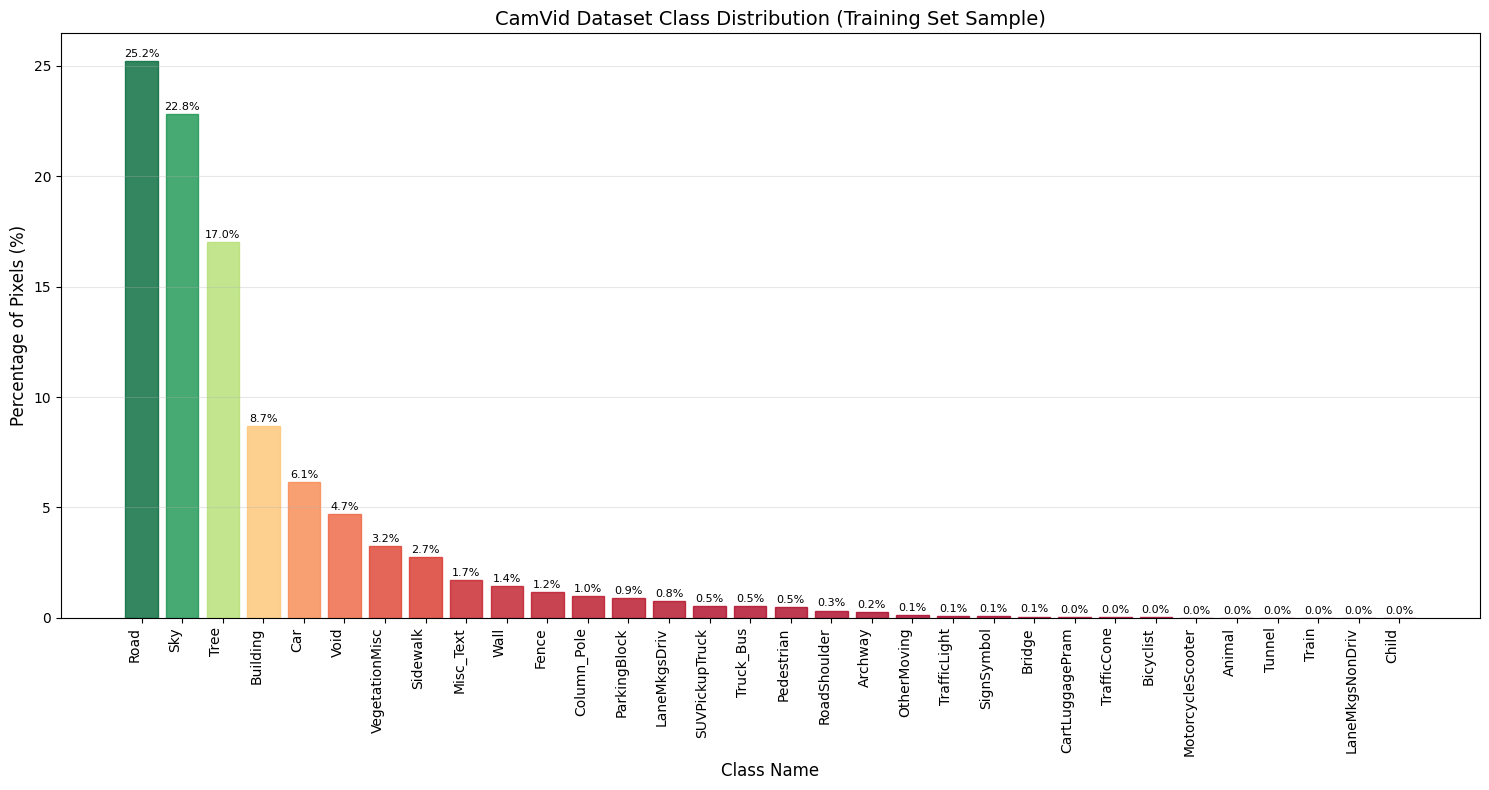

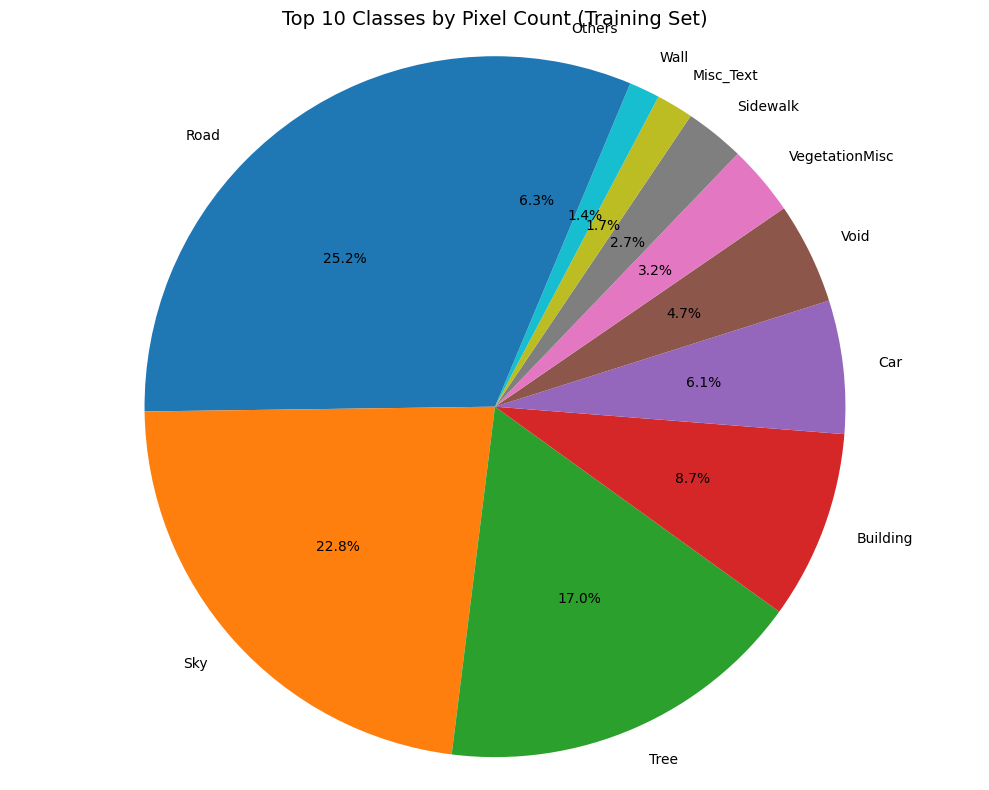

✓ Block 7 executed successfully!
Visualizations saved to:
  - results/class_distribution_plot.png
  - results/class_distribution_pie.png

Class imbalance ratio (max/min): 8715566.00x


In [12]:
# Block 7: Visualize Class Distribution

# Create visualization of class distribution
plt.figure(figsize=(15, 8))

# Sort classes by frequency for better visualization
sorted_indices = np.argsort(class_distribution)[::-1]
sorted_names = [class_names[i] for i in sorted_indices]
sorted_counts = class_distribution[sorted_indices]
sorted_percentages = (sorted_counts / total_pixels) * 100

# Create bar plot
bars = plt.bar(range(len(sorted_names)), sorted_percentages, color='steelblue', alpha=0.8)

# Color code bars by frequency (red for rare, green for common)
colors = plt.cm.RdYlGn(sorted_percentages / sorted_percentages.max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Class Name', fontsize=12)
plt.ylabel('Percentage of Pixels (%)', fontsize=12)
plt.title('CamVid Dataset Class Distribution (Training Set Sample)', fontsize=14)
plt.xticks(range(len(sorted_names)), sorted_names, rotation=90, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (count, pct) in enumerate(zip(sorted_counts, sorted_percentages)):
    plt.text(i, pct + 0.1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('results/class_distribution_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a pie chart for top 10 classes
plt.figure(figsize=(10, 8))
top_10_indices = sorted_indices[:10]
top_10_names = [class_names[i] for i in top_10_indices]
top_10_counts = class_distribution[top_10_indices]
other_count = class_distribution[sorted_indices[10:]].sum()

# Combine data
pie_labels = top_10_names + ['Others']
pie_counts = np.append(top_10_counts, other_count)

plt.pie(pie_counts, labels=pie_labels, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Classes by Pixel Count (Training Set)', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.savefig('results/class_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Block 7 executed successfully!")
print("Visualizations saved to:")
print("  - results/class_distribution_plot.png")
print("  - results/class_distribution_pie.png")
print(f"\nClass imbalance ratio (max/min): {class_distribution.max() / (class_distribution.min() + 1):.2f}x")

In [ ]:
# Block 8 Fixed: Create Data Loaders with Proper Worker Configuration

# Determine optimal batch size based on GPU memory (8GB for RTX 4060)
batch_size = 4

# For Windows, use 0 workers to avoid multiprocessing issues
# For Linux, can use 2-4 workers
num_workers = 2  # Set to 0 for Windows compatibility

# Create data loaders
train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=num_workers,
                         pin_memory=True if torch.cuda.is_available() else False,
                         drop_last=True)

val_loader = DataLoader(val_dataset,
                       batch_size=batch_size,
                       shuffle=False,
                       num_workers=num_workers,
                       pin_memory=True if torch.cuda.is_available() else False)

test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=True if torch.cuda.is_available() else False)

# Calculate steps per epoch
steps_per_epoch = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

print("✓ Block 8 executed successfully!")
print(f"Data loaders created:")
print(f"  - Batch size: {batch_size}")
print(f"  - Number of workers: {num_workers} (Windows-compatible)")
print(f"  - Training batches per epoch: {steps_per_epoch}")
print(f"  - Validation batches: {val_steps}")
print(f"  - Test batches: {test_steps}")
print(f"  - Total training samples per epoch: {steps_per_epoch * batch_size}")

# Test data loading with timeout
try:
    print("\nTesting data loader...")
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch
    print(f"  - Image batch shape: {images.shape}")
    print(f"  - Label batch shape: {labels.shape}")
    print(f"  - Image data type: {images.dtype}")
    print(f"  - Label data type: {labels.dtype}")
    print(f"  - Label value range: [{labels.min().item()}, {labels.max().item()}]")
    print("  - Data loader test: PASSED ✓")
except Exception as e:
    print(f"  - Data loader test: FAILED - {str(e)}")

✓ Block 8 executed successfully!
Data loaders created:
  - Batch size: 4
  - Number of workers: 2 (Windows-compatible)
  - Training batches per epoch: 92
  - Validation batches: 25
  - Test batches: 58
  - Total training samples per epoch: 368

Testing data loader...
  - Image batch shape: torch.Size([4, 3, 352, 480])
  - Label batch shape: torch.Size([4, 352, 480])
  - Image data type: torch.float32
  - Label data type: torch.int32
  - Label value range: [0, 31]
  - Data loader test: PASSED ✓


Visualizing training samples...


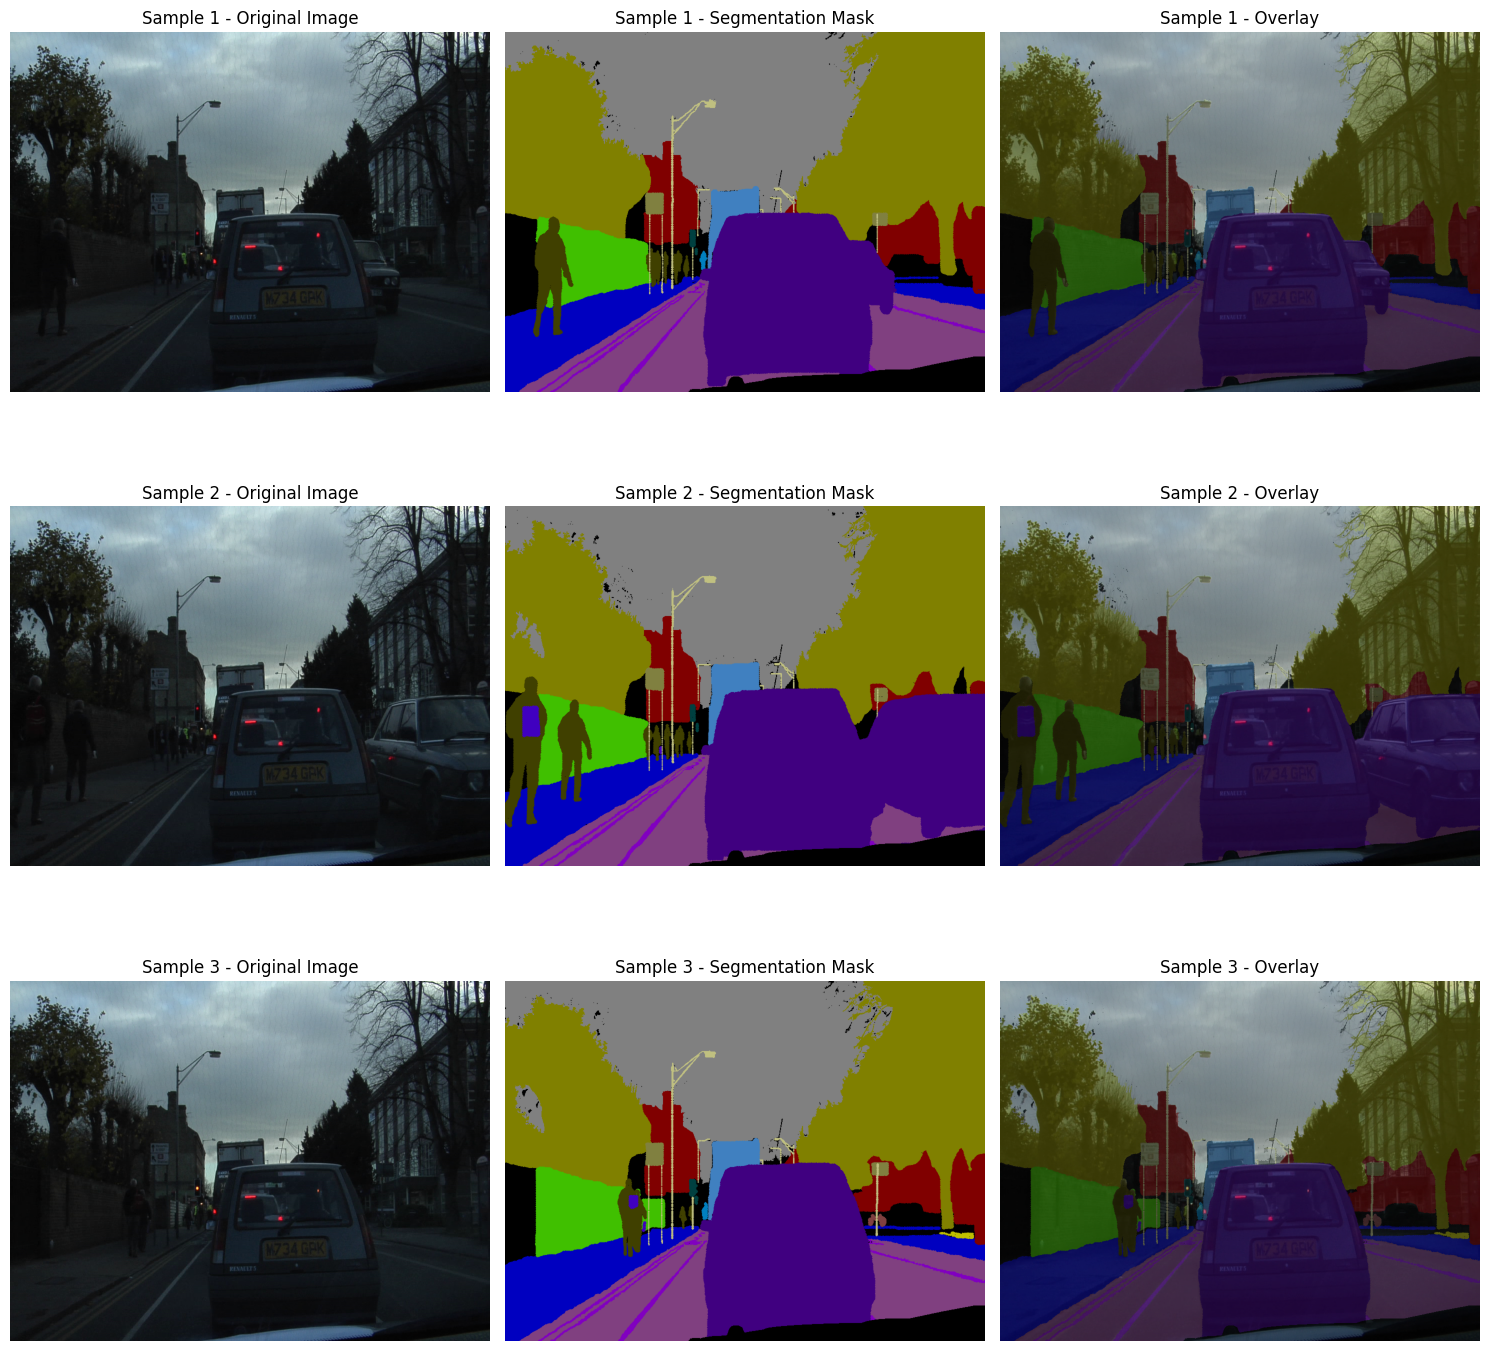

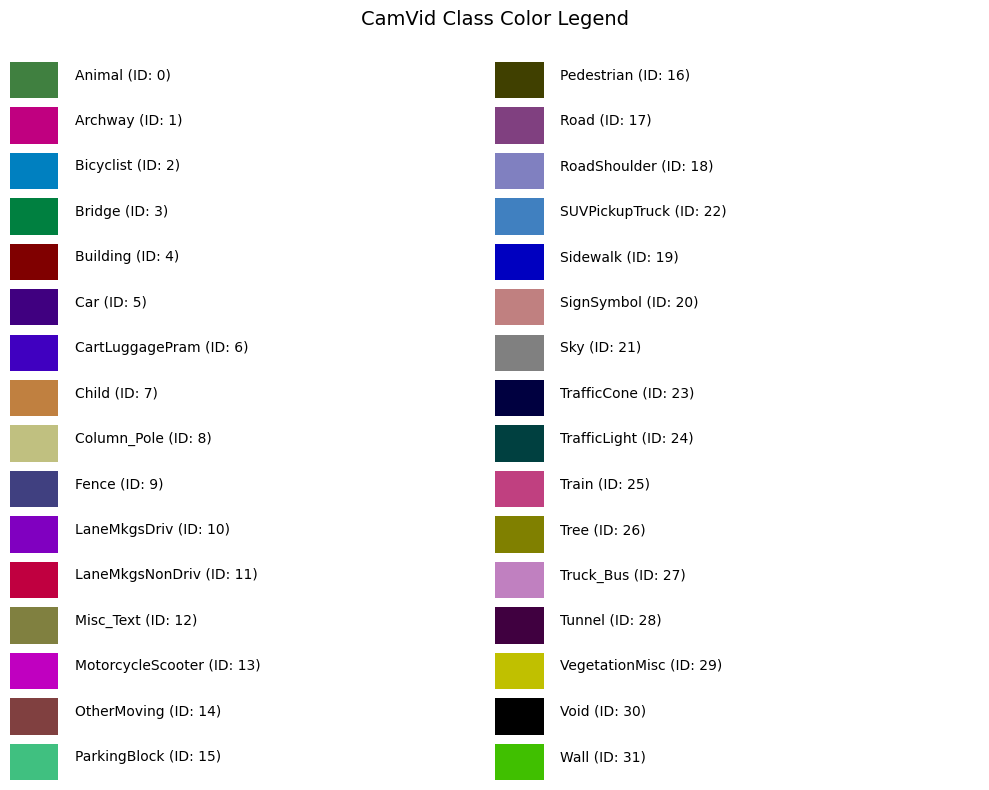


✓ Block 9 executed successfully!
Visualizations saved to:
  - results/sample_visualizations.png
  - results/class_color_legend.png


In [ ]:
# Block 9: Visualize Sample Images and Masks

def visualize_samples(dataset, color_mapping, num_samples=3):
    """
    Visualize sample images with their segmentation masks
    """
    # Create a reverse mapping from class index to RGB values for visualization
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axs = axs.reshape(1, -1)

    for i in range(num_samples):
        # Get raw image and label without transforms
        image_path = dataset.image_files[i]
        label_path = dataset.label_files[i]

        # Load raw images
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(label_path)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        # Convert label to class indices
        label_indices = dataset.convert_rgb_to_class(label)

        # Convert label to RGB for visualization
        label_rgb = np.zeros((label_indices.shape[0], label_indices.shape[1], 3), dtype=np.uint8)
        for class_idx, rgb in reverse_color_mapping.items():
            label_rgb[label_indices == class_idx] = rgb

        # Create overlay (image with semi-transparent mask)
        overlay = image.copy()
        mask_overlay = cv2.addWeighted(overlay, 0.6, label_rgb, 0.4, 0)

        # Plot the image, label, and overlay
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Sample {i + 1} - Original Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(label_rgb)
        axs[i, 1].set_title(f'Sample {i + 1} - Segmentation Mask')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(mask_overlay)
        axs[i, 2].set_title(f'Sample {i + 1} - Overlay')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('results/sample_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# Visualize training samples
print("Visualizing training samples...")
fig = visualize_samples(train_dataset, color_mapping, num_samples=3)

# Create a color legend for classes
def create_class_legend(color_mapping, class_names):
    """Create a legend showing class colors"""
    fig, ax = plt.subplots(figsize=(10, 8))

    # Sort classes alphabetically
    sorted_indices = np.argsort(class_names)

    # Create color patches
    patches = []
    labels = []

    for idx in sorted_indices:
        rgb = [k for k, v in color_mapping.items() if v == idx][0]
        color = np.array(rgb) / 255.0  # Normalize to [0, 1]
        rect = plt.Rectangle((0, 0), 1, 1, fc=color)
        patches.append(rect)
        labels.append(f"{class_names[idx]} (ID: {idx})")

    # Create legend
    n_cols = 2
    n_rows = (len(patches) + n_cols - 1) // n_cols

    for i, (patch, label) in enumerate(zip(patches, labels)):
        row = i % n_rows
        col = i // n_rows
        ax.add_patch(plt.Rectangle((col * 3, n_rows - row - 1), 0.3, 0.8,
                                  fc=patch.get_facecolor()))
        ax.text(col * 3 + 0.4, n_rows - row - 0.5, label,
               va='center', fontsize=10)

    ax.set_xlim(0, n_cols * 3)
    ax.set_ylim(0, n_rows)
    ax.axis('off')
    ax.set_title('CamVid Class Color Legend', fontsize=14, pad=20)

    plt.tight_layout()
    plt.savefig('results/class_color_legend.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create color legend
create_class_legend(color_mapping, class_names)

print("\n✓ Block 9 executed successfully!")
print("Visualizations saved to:")
print("  - results/sample_visualizations.png")
print("  - results/class_color_legend.png")

In [ ]:
# Block 10: FCN Segmentation Model

class FCNSegmentation(nn.Module):
    """
    Fully Convolutional Network for Semantic Segmentation
    Using ResNet-50 as encoder backbone
    """
    def __init__(self, num_classes):
        super(FCNSegmentation, self).__init__()

        # ResNet-50 as encoder backbone
        resnet = models.resnet50(pretrained=True)

        # Encoder using ResNet50 layers, excluding the fully connected part
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Decoder for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.ConvTranspose2d(128, num_classes, kernel_size=4, stride=2, padding=1),
            nn.Upsample(size=(352, 480), mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create FCN model
model_fcn = FCNSegmentation(num_classes=32).to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model_fcn.parameters())
trainable_params = sum(p.numel() for p in model_fcn.parameters() if p.requires_grad)

print("✓ Block 10 executed successfully!")
print(f"FCN Model created:")
print(f"  - Backbone: ResNet-50 (pretrained)")
print(f"  - Number of classes: 32")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Model size: {total_params * 4 / 1024**2:.2f} MB")

# Test model with a sample batch
with torch.no_grad():
    test_input = torch.randn(1, 3, 352, 480).to(device)
    test_output = model_fcn(test_input)
    print(f"\nModel test:")
    print(f"  - Input shape: {test_input.shape}")
    print(f"  - Output shape: {test_output.shape}")
    print(f"  - Output channels match classes: {test_output.shape[1] == 32}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


✓ Block 10 executed successfully!
FCN Model created:
  - Backbone: ResNet-50 (pretrained)
  - Number of classes: 32
  - Total parameters: 68,143,840
  - Trainable parameters: 68,143,840
  - Model size: 259.95 MB

Model test:
  - Input shape: torch.Size([1, 3, 352, 480])
  - Output shape: torch.Size([1, 32, 352, 480])
  - Output channels match classes: True


In [ ]:
# Block 11: U-Net with Attention Model

class AttentionBlock(nn.Module):
    """
    Attention mechanism for U-Net
    Helps the model focus on relevant features
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNetResNet50(nn.Module):
    """
    U-Net with ResNet50 backbone and attention mechanism
    """
    def __init__(self, num_classes):
        super(UNetResNet50, self).__init__()

        # Pre-trained ResNet-50 backbone
        resnet = resnet50(weights='IMAGENET1K_V1')

        # Encoder layers
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder2 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder with attention
        self.attention5 = AttentionBlock(F_g=2048, F_l=1024, F_int=512)
        self.decoder5 = nn.Sequential(
            nn.Conv2d(2048 + 1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        self.attention4 = AttentionBlock(F_g=1024, F_l=512, F_int=256)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        self.attention3 = AttentionBlock(F_g=512, F_l=256, F_int=128)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        self.attention2 = AttentionBlock(F_g=256, F_l=64, F_int=32)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)  # (B, 64, H/2, W/2)
        e2 = self.encoder2(e1) # (B, 256, H/4, W/4)
        e3 = self.encoder3(e2) # (B, 512, H/8, W/8)
        e4 = self.encoder4(e3) # (B, 1024, H/16, W/16)
        e5 = self.encoder5(e4) # (B, 2048, H/32, W/32)

        # Decoder with attention
        d5 = F.interpolate(e5, size=e4.size()[2:], mode='bilinear', align_corners=True)
        e4_att = self.attention5(d5, e4)
        d5 = torch.cat((d5, e4_att), dim=1)
        d5 = self.decoder5(d5)

        d4 = F.interpolate(d5, size=e3.size()[2:], mode='bilinear', align_corners=True)
        e3_att = self.attention4(d4, e3)
        d4 = torch.cat((d4, e3_att), dim=1)
        d4 = self.decoder4(d4)

        d3 = F.interpolate(d4, size=e2.size()[2:], mode='bilinear', align_corners=True)
        e2_att = self.attention3(d3, e2)
        d3 = torch.cat((d3, e2_att), dim=1)
        d3 = self.decoder3(d3)

        d2 = F.interpolate(d3, size=e1.size()[2:], mode='bilinear', align_corners=True)
        e1_att = self.attention2(d2, e1)
        d2 = torch.cat((d2, e1_att), dim=1)
        d2 = self.decoder2(d2)

        # Final output
        output = self.final_conv(d2)
        output = F.interpolate(output, size=(352, 480), mode='bilinear', align_corners=True)

        return output

# Create U-Net model
model_unet = UNetResNet50(num_classes=32).to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model_unet.parameters())
trainable_params = sum(p.numel() for p in model_unet.parameters() if p.requires_grad)

print("✓ Block 11 executed successfully!")
print(f"U-Net Model created:")
print(f"  - Backbone: ResNet-50 (pretrained)")
print(f"  - Features: Attention mechanism")
print(f"  - Number of classes: 32")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Model size: {total_params * 4 / 1024**2:.2f} MB")

# Test model
with torch.no_grad():
    test_input = torch.randn(1, 3, 352, 480).to(device)
    test_output = model_unet(test_input)
    print(f"\nModel test:")
    print(f"  - Input shape: {test_input.shape}")
    print(f"  - Output shape: {test_output.shape}")
    print(f"  - Output channels match classes: {test_output.shape[1] == 32}")

✓ Block 11 executed successfully!
U-Net Model created:
  - Backbone: ResNet-50 (pretrained)
  - Features: Attention mechanism
  - Number of classes: 32
  - Total parameters: 62,940,044
  - Trainable parameters: 62,940,044
  - Model size: 240.10 MB

Model test:
  - Input shape: torch.Size([1, 3, 352, 480])
  - Output shape: torch.Size([1, 32, 352, 480])
  - Output channels match classes: True


In [ ]:
# Block 12: DeepLabV3+ Model

class DeepLabV3Plus(nn.Module):
    """
    DeepLabV3+ model for semantic segmentation
    Uses atrous convolution for dense feature extraction
    """
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        # Load the pre-trained DeepLabV3+ model
        self.model = segmentation.deeplabv3_resnet50(pretrained=True)

        # Modify the classifier to output num_classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

        # Also modify auxiliary classifier if it exists
        if hasattr(self.model, 'aux_classifier') and self.model.aux_classifier is not None:
            self.model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

    def forward(self, x):
        # Forward pass - only use main output during inference
        return self.model(x)['out']

# Create DeepLabV3+ model
model_deeplab = DeepLabV3Plus(num_classes=32)

# Convert BatchNorm to GroupNorm for better stability with small batch sizes
def convert_bn_to_gn(module, num_groups=32):
    """Recursively replace all BatchNorm2d layers with GroupNorm."""
    for child_name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            # Ensure num_groups divides num_channels
            num_channels = child.num_features
            # Find a suitable number of groups
            for g in [32, 16, 8, 4, 2, 1]:
                if num_channels % g == 0:
                    num_groups = g
                    break
            setattr(module, child_name, nn.GroupNorm(num_groups=num_groups, num_channels=num_channels))
        else:
            convert_bn_to_gn(child)

# Apply GroupNorm conversion
convert_bn_to_gn(model_deeplab)
model_deeplab = model_deeplab.to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model_deeplab.parameters())
trainable_params = sum(p.numel() for p in model_deeplab.parameters() if p.requires_grad)

print("✓ Block 12 executed successfully!")
print(f"DeepLabV3+ Model created:")
print(f"  - Backbone: ResNet-50 (pretrained)")
print(f"  - Features: Atrous Spatial Pyramid Pooling (ASPP)")
print(f"  - Number of classes: 32")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Model size: {total_params * 4 / 1024**2:.2f} MB")
print(f"  - BatchNorm converted to GroupNorm for stability")

# Test model
with torch.no_grad():
    test_input = torch.randn(1, 3, 352, 480).to(device)
    test_output = model_deeplab(test_input)
    print(f"\nModel test:")
    print(f"  - Input shape: {test_input.shape}")
    print(f"  - Output shape: {test_output.shape}")
    print(f"  - Output channels match classes: {test_output.shape[1] == 32}")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 172MB/s]  


✓ Block 12 executed successfully!
DeepLabV3+ Model created:
  - Backbone: ResNet-50 (pretrained)
  - Features: Atrous Spatial Pyramid Pooling (ASPP)
  - Number of classes: 32
  - Total parameters: 42,009,728
  - Trainable parameters: 42,009,728
  - Model size: 160.25 MB
  - BatchNorm converted to GroupNorm for stability

Model test:
  - Input shape: torch.Size([1, 3, 352, 480])
  - Output shape: torch.Size([1, 32, 352, 480])
  - Output channels match classes: True


In [ ]:
# Block 13: Loss Functions (Dice + Focal + Cross-Entropy)

# Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    """
    Dice loss for handling class imbalance
    Good for segmentation tasks
    """
    # Convert target to one-hot encoding
    target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    pred = pred.contiguous()
    target_one_hot = target_one_hot.contiguous()

    # Compute Dice loss
    intersection = (pred * target_one_hot).sum(dim=2).sum(dim=2)
    dice_score = (2. * intersection + smooth) / (
        pred.sum(dim=2).sum(dim=2) + target_one_hot.sum(dim=2).sum(dim=2) + smooth
    )

    return 1 - dice_score.mean()

# Focal Loss
class FocalLoss(nn.Module):
    """
    Focal loss for addressing extreme class imbalance
    Focuses learning on hard examples
    """
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Jaccard/IoU Loss
class JaccardLoss(nn.Module):
    """
    Jaccard (IoU) loss for segmentation
    """
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Convert y_true to one-hot encoding
        y_true_one_hot = F.one_hot(y_true, num_classes=y_pred.shape[1]).permute(0, 3, 1, 2).float()

        # Apply softmax to predictions
        y_pred = F.softmax(y_pred, dim=1)

        # Flatten the tensors
        y_pred_flat = y_pred.contiguous().view(y_pred.shape[0], y_pred.shape[1], -1)
        y_true_flat = y_true_one_hot.contiguous().view(y_true_one_hot.shape[0], y_true_one_hot.shape[1], -1)

        # Compute intersection and union
        intersection = (y_pred_flat * y_true_flat).sum(dim=2)
        union = y_pred_flat.sum(dim=2) + y_true_flat.sum(dim=2) - intersection

        # Compute Jaccard Index (IoU)
        iou = (intersection + self.smooth) / (union + self.smooth)

        # Return Jaccard loss (1 - IoU)
        return 1 - iou.mean()

# Combined Loss
class CombinedLoss(nn.Module):
    """
    Combines multiple loss functions with class weighting
    """
    def __init__(self, class_weights=None, dice_weight=0.3, focal_weight=0.3,
                 ce_weight=0.4, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.ce_weight = ce_weight
        self.focal_loss = FocalLoss(alpha=1, gamma=2)
        self.jaccard_loss = JaccardLoss(smooth=smooth)

        # Class weights for cross-entropy
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        else:
            self.class_weights = None

    def forward(self, y_pred, y_true):
        # Apply softmax to predictions
        y_pred_softmax = F.softmax(y_pred, dim=1)

        # Calculate individual losses
        dice = dice_loss(y_pred_softmax, y_true)
        focal = self.focal_loss(y_pred, y_true)

        # Weighted cross-entropy
        if self.class_weights is not None:
            ce = F.cross_entropy(y_pred, y_true, weight=self.class_weights)
        else:
            ce = F.cross_entropy(y_pred, y_true)

        # Combine losses
        total_loss = (self.dice_weight * dice +
                     self.focal_weight * focal +
                     self.ce_weight * ce)

        return total_loss, {'dice': dice.item(), 'focal': focal.item(), 'ce': ce.item()}

# Create loss function with class weights
combined_loss = CombinedLoss(
    class_weights=class_weights,
    dice_weight=0.3,
    focal_weight=0.3,
    ce_weight=0.4
)

print("✓ Block 13 executed successfully!")
print("Loss functions created:")
print("  - Dice Loss (30%): Handles class imbalance")
print("  - Focal Loss (30%): Focuses on hard examples")
print("  - Cross-Entropy Loss (40%): Standard classification loss")
print("  - Class weights applied for handling imbalance")
print(f"\nLoss weights sum: {0.3 + 0.3 + 0.4} = 1.0 ✓")

✓ Block 13 executed successfully!
Loss functions created:
  - Dice Loss (30%): Handles class imbalance
  - Focal Loss (30%): Focuses on hard examples
  - Cross-Entropy Loss (40%): Standard classification loss
  - Class weights applied for handling imbalance

Loss weights sum: 1.0 = 1.0 ✓


In [ ]:
# Block 14: Training Utilities and Metrics

class EarlyStopping:
    """
    Early stopping to prevent overfitting
    """
    def __init__(self, patience=5, delta=0.01, verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.inf
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        self.best_model = model.state_dict().copy()
        self.val_loss_min = val_loss

class MetricsTracker:
    """
    Track and compute segmentation metrics
    """
    def __init__(self, num_classes, class_names):
        self.num_classes = num_classes
        self.class_names = class_names
        self.reset()

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))
        self.total_pixels = 0
        self.correct_pixels = 0

    def update(self, predictions, targets):
        """Update metrics with batch predictions"""
        predictions = predictions.cpu().numpy()
        targets = targets.cpu().numpy()

        # Update confusion matrix
        for pred, target in zip(predictions, targets):
            self.confusion_matrix += self._fast_hist(target.flatten(), pred.flatten())

        # Update pixel accuracy
        self.total_pixels += targets.size
        self.correct_pixels += (predictions == targets).sum()

    def _fast_hist(self, label_true, label_pred):
        """Compute confusion matrix"""
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.num_classes ** 2
        ).reshape(self.num_classes, self.num_classes)
        return hist

    def get_metrics(self):
        """Calculate all metrics"""
        # Pixel accuracy
        pixel_acc = self.correct_pixels / self.total_pixels

        # Mean pixel accuracy (per-class accuracy)
        class_acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        class_acc = np.nanmean(class_acc)

        # IoU per class
        iou = np.diag(self.confusion_matrix) / (
            self.confusion_matrix.sum(axis=1) +
            self.confusion_matrix.sum(axis=0) -
            np.diag(self.confusion_matrix)
        )

        # Mean IoU
        mean_iou = np.nanmean(iou)

        # Frequency weighted IoU
        freq = self.confusion_matrix.sum(axis=1) / self.confusion_matrix.sum()
        freq_iou = (freq[freq > 0] * iou[freq > 0]).sum()

        return {
            'pixel_accuracy': pixel_acc,
            'mean_pixel_accuracy': class_acc,
            'mean_iou': mean_iou,
            'frequency_weighted_iou': freq_iou,
            'per_class_iou': iou,
            'confusion_matrix': self.confusion_matrix
        }

def save_training_progress(epoch, model_name, train_metrics, val_metrics, save_dir='results'):
    """Save training metrics to file"""
    os.makedirs(save_dir, exist_ok=True)

    filename = os.path.join(save_dir, f'{model_name}_training_log.txt')

    with open(filename, 'a') as f:
        if epoch == 0:
            f.write(f"Training Log for {model_name}\n")
            f.write("="*60 + "\n")

        f.write(f"\nEpoch {epoch + 1}:\n")
        f.write(f"  Train Loss: {train_metrics['loss']:.4f}\n")
        f.write(f"  Train Acc: {train_metrics['accuracy']:.4f}\n")
        f.write(f"  Val Loss: {val_metrics['loss']:.4f}\n")
        f.write(f"  Val Acc: {val_metrics['accuracy']:.4f}\n")
        f.write(f"  Val mIoU: {val_metrics.get('mean_iou', 0):.4f}\n")
        f.write("-"*40 + "\n")

print("✓ Block 14 executed successfully!")
print("Training utilities created:")
print("  - EarlyStopping: Prevents overfitting")
print("  - MetricsTracker: Tracks IoU, accuracy, confusion matrix")
print("  - save_training_progress: Logs training metrics to file")
print("\nMetrics to be tracked:")
print("  - Pixel Accuracy")
print("  - Mean Pixel Accuracy")
print("  - Mean IoU (mIoU)")
print("  - Frequency Weighted IoU")
print("  - Per-class IoU")
print("  - Confusion Matrix")

✓ Block 14 executed successfully!
Training utilities created:
  - EarlyStopping: Prevents overfitting
  - MetricsTracker: Tracks IoU, accuracy, confusion matrix
  - save_training_progress: Logs training metrics to file

Metrics to be tracked:
  - Pixel Accuracy
  - Mean Pixel Accuracy
  - Mean IoU (mIoU)
  - Frequency Weighted IoU
  - Per-class IoU
  - Confusion Matrix


In [18]:
import torch.optim as optim

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Block 15: Optimizers and Learning Rate Schedulers

# Loss function instance
criterion = combined_loss

# Early Stopping instances for each model
early_stopping_fcn = EarlyStopping(patience=7, delta=0.001, verbose=True)
early_stopping_unet = EarlyStopping(patience=7, delta=0.001, verbose=True)
early_stopping_deeplab = EarlyStopping(patience=7, delta=0.001, verbose=True)

# Optimizers with different learning rates for better convergence
optimizer_fcn = optim.Adam(model_fcn.parameters(),
                          lr=1e-4,
                          weight_decay=1e-4,
                          betas=(0.9, 0.999))

optimizer_unet = optim.Adam(model_unet.parameters(),
                           lr=1e-4,
                           weight_decay=1e-5,
                           betas=(0.9, 0.999))

optimizer_deeplab = optim.Adam(model_deeplab.parameters(),
                              lr=1e-4,
                              weight_decay=1e-5,
                              betas=(0.9, 0.999))

# Learning Rate Schedulers
scheduler_fcn = ReduceLROnPlateau(optimizer_fcn,
                                 mode='min',
                                 factor=0.5,
                                 patience=5,
                                 min_lr=1e-6)

scheduler_unet = ReduceLROnPlateau(optimizer_unet,
                                  mode='min',
                                  factor=0.5,
                                  patience=3,
                                  min_lr=1e-6)

scheduler_deeplab = ReduceLROnPlateau(optimizer_deeplab,
                                     mode='min',
                                     factor=0.5,
                                     patience=3,
                                     min_lr=1e-6)

# Create metrics trackers for each model
metrics_tracker_fcn = MetricsTracker(num_classes=32, class_names=class_names)
metrics_tracker_unet = MetricsTracker(num_classes=32, class_names=class_names)
metrics_tracker_deeplab = MetricsTracker(num_classes=32, class_names=class_names)

print("✓ Block 15 executed successfully!")
print("Optimization setup complete:")
print("\nOptimizers:")
print("  - FCN: Adam (lr=1e-4, weight_decay=1e-4)")
print("  - U-Net: Adam (lr=1e-4, weight_decay=1e-5)")
print("  - DeepLab: Adam (lr=1e-4, weight_decay=1e-5)")
print("\nLR Schedulers:")
print("  - ReduceLROnPlateau (factor=0.5)")
print("  - FCN patience: 5 epochs")
print("  - U-Net/DeepLab patience: 3 epochs")
print("\nEarly Stopping:")
print("  - Patience: 7 epochs")
print("  - Delta: 0.001")

✓ Block 15 executed successfully!
Optimization setup complete:

Optimizers:
  - FCN: Adam (lr=1e-4, weight_decay=1e-4)
  - U-Net: Adam (lr=1e-4, weight_decay=1e-5)
  - DeepLab: Adam (lr=1e-4, weight_decay=1e-5)

LR Schedulers:
  - ReduceLROnPlateau (factor=0.5)
  - FCN patience: 5 epochs
  - U-Net/DeepLab patience: 3 epochs

Early Stopping:
  - Patience: 7 epochs
  - Delta: 0.001


In [ ]:
# Block 16: Comprehensive Training Loop

def training_loop(model, optimizer, scheduler, early_stopping, metrics_tracker, model_name="model"):
    """
    Comprehensive training loop with metrics tracking and visualization
    """
    model.to(device)
    num_epochs = 100

    # History tracking
    history = {
        'train_loss': [], 'train_acc': [], 'train_miou': [],
        'val_loss': [], 'val_acc': [], 'val_miou': [],
        'lr': []
    }

    # Best model tracking
    best_val_miou = 0.0
    best_epoch = 0

    print(f"\nStarting training for {model_name}...")
    print("="*60)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct_pixels = 0
        train_total_pixels = 0
        metrics_tracker.reset()

        # Progress bar for training
        train_pbar = train_loader

        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate loss
            loss, loss_components = criterion(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            train_correct_pixels += (predictions == masks).sum().item()
            train_total_pixels += masks.numel()

            # Update metrics tracker
            metrics_tracker.update(predictions, masks)

            # Print progress every 20 batches
            if batch_idx % 20 == 0:
                print(f"  Batch [{batch_idx}/{len(train_loader)}] - Loss: {loss.item():.4f}")

        # Calculate training metrics
        train_loss /= len(train_loader)
        train_acc = train_correct_pixels / train_total_pixels
        train_metrics = metrics_tracker.get_metrics()
        train_miou = train_metrics['mean_iou']

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct_pixels = 0
        val_total_pixels = 0
        metrics_tracker.reset()

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                loss, _ = criterion(outputs, masks)
                val_loss += loss.item()

                predictions = torch.argmax(outputs, dim=1)
                val_correct_pixels += (predictions == masks).sum().item()
                val_total_pixels += masks.numel()

                metrics_tracker.update(predictions, masks)

        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_acc = val_correct_pixels / val_total_pixels
        val_metrics = metrics_tracker.get_metrics()
        val_miou = val_metrics['mean_iou']

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_miou'].append(train_miou)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_miou'].append(val_miou)
        history['lr'].append(current_lr)

        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, mIoU: {train_miou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, mIoU: {val_miou:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # Save best model based on validation mIoU
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_miou': val_miou,
                'val_loss': val_loss,
            }, f'results/best_{model_name}_model.pth')
            print(f"  → New best model saved! (mIoU: {val_miou:.4f})")

        # Save training progress
        save_training_progress(epoch, model_name,
                             {'loss': train_loss, 'accuracy': train_acc, 'mean_iou': train_miou},
                             {'loss': val_loss, 'accuracy': val_acc, 'mean_iou': val_miou})

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        # Clear GPU cache
        torch.cuda.empty_cache()

    print(f"\nTraining completed for {model_name}")
    print(f"Best validation mIoU: {best_val_miou:.4f} at epoch {best_epoch+1}")

    # Load best model
    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    return history, val_metrics

print("✓ Block 16 executed successfully!")
print("Comprehensive training loop created with:")
print("  - Loss tracking (train/val)")
print("  - Accuracy tracking (pixel-wise)")
print("  - mIoU tracking")
print("  - Learning rate tracking")
print("  - Best model saving")
print("  - Progress logging to file")
print("  - Early stopping")
print("  - GPU memory management")

✓ Block 16 executed successfully!
Comprehensive training loop created with:
  - Loss tracking (train/val)
  - Accuracy tracking (pixel-wise)
  - mIoU tracking
  - Learning rate tracking
  - Best model saving
  - Progress logging to file
  - Early stopping
  - GPU memory management


In [ ]:
# Block 17: Training History Visualization Functions

def plot_training_history(history, model_name):
    """
    Plot comprehensive training history
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{model_name} Training History', fontsize=16)

    # Plot Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Accuracy Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot mIoU
    axes[0, 2].plot(history['train_miou'], label='Train mIoU', linewidth=2)
    axes[0, 2].plot(history['val_miou'], label='Val mIoU', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('mIoU')
    axes[0, 2].set_title('Mean IoU Curves')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Learning Rate
    axes[1, 0].plot(history['lr'], label='Learning Rate', linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Loss vs mIoU correlation
    axes[1, 1].scatter(history['val_loss'], history['val_miou'], alpha=0.6)
    axes[1, 1].set_xlabel('Validation Loss')
    axes[1, 1].set_ylabel('Validation mIoU')
    axes[1, 1].set_title('Loss vs mIoU Correlation')
    axes[1, 1].grid(True, alpha=0.3)

    # Plot Train vs Val metrics
    axes[1, 2].plot(history['train_acc'], history['val_acc'], 'o-', alpha=0.6)
    axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[1, 2].set_xlabel('Train Accuracy')
    axes[1, 2].set_ylabel('Val Accuracy')
    axes[1, 2].set_title('Train vs Val Accuracy')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'results/{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(confusion_matrix, class_names, model_name):
    """
    Plot confusion matrix with better visualization
    """
    # Normalize confusion matrix
    cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Plot raw confusion matrix
    im1 = ax1.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
    ax1.set_title(f'{model_name} - Confusion Matrix (Raw Counts)', fontsize=14)
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Count', rotation=270, labelpad=20)

    # Plot normalized confusion matrix
    im2 = ax2.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    ax2.set_title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=14)
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Proportion', rotation=270, labelpad=20)

    # Set ticks and labels
    for ax in [ax1, ax2]:
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=90, ha='right')
        ax.set_yticklabels(class_names)

    plt.tight_layout()
    plt.savefig(f'results/{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_model_summary(model, model_name, input_size=(3, 352, 480)):
    """
    Save model architecture summary to file
    """
    summary_file = f'results/{model_name}_architecture_summary.txt'

    with open(summary_file, 'w') as f:
        f.write(f"{model_name} Architecture Summary\n")
        f.write("="*60 + "\n\n")

        # Model parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        f.write(f"Total Parameters: {total_params:,}\n")
        f.write(f"Trainable Parameters: {trainable_params:,}\n")
        f.write(f"Model Size: {total_params * 4 / 1024**2:.2f} MB\n\n")

        # Layer information
        f.write("Layer-wise Information:\n")
        f.write("-"*60 + "\n")

        for name, param in model.named_parameters():
            f.write(f"{name:<50} {str(param.shape):<20} {param.numel():>10,}\n")

    print(f"Model summary saved to: {summary_file}")

print("✓ Block 17 executed successfully!")
print("Visualization functions created:")
print("  - plot_training_history: Comprehensive training curves")
print("  - plot_confusion_matrix: Raw and normalized matrices")
print("  - save_model_summary: Architecture details to file")
print("\nReady to start training!")

✓ Block 17 executed successfully!
Visualization functions created:
  - plot_training_history: Comprehensive training curves
  - plot_confusion_matrix: Raw and normalized matrices
  - save_model_summary: Architecture details to file

Ready to start training!


In [ ]:
# Block 18: Comprehensive Metrics and Model Saving

import time
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_comprehensive_metrics(model, dataloader, model_name, save_results=True):
    """
    Calculate comprehensive metrics including F1, precision, recall, and speed
    """
    model.eval()
    metrics_tracker = MetricsTracker(num_classes=32, class_names=class_names)

    all_predictions = []
    all_targets = []

    # Timing metrics
    inference_times = []

    print(f"\nCalculating comprehensive metrics for {model_name}...")

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)

            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            predictions = torch.argmax(outputs, dim=1)

            # Update metrics tracker
            metrics_tracker.update(predictions, masks)

            # Collect for sklearn metrics
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())

            if batch_idx % 10 == 0:
                print(f"  Processing batch {batch_idx}/{len(dataloader)}")

    # Get basic metrics
    metrics = metrics_tracker.get_metrics()

    # Calculate sklearn metrics
    f1_micro = f1_score(all_targets, all_predictions, average='micro')
    f1_macro = f1_score(all_targets, all_predictions, average='macro')
    f1_weighted = f1_score(all_targets, all_predictions, average='weighted')
    f1_per_class = f1_score(all_targets, all_predictions, average=None, labels=range(32))

    precision_macro = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall_macro = recall_score(all_targets, all_predictions, average='macro', zero_division=0)

    # Speed metrics
    avg_inference_time = np.mean(inference_times)
    fps = 1.0 / avg_inference_time * dataloader.batch_size

    # Compile results
    comprehensive_metrics = {
        'pixel_accuracy': metrics['pixel_accuracy'],
        'mean_pixel_accuracy': metrics['mean_pixel_accuracy'],
        'mean_iou': metrics['mean_iou'],
        'frequency_weighted_iou': metrics['frequency_weighted_iou'],
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'avg_inference_time_per_batch': avg_inference_time,
        'fps': fps,
        'per_class_iou': metrics['per_class_iou']
    }

    if save_results:
        # Save detailed results to file
        results_file = f'results/{model_name}_comprehensive_metrics.txt'
        with open(results_file, 'w') as f:
            f.write(f"Comprehensive Metrics for {model_name}\n")
            f.write("="*60 + "\n\n")

            f.write("Overall Metrics:\n")
            f.write("-"*40 + "\n")
            f.write(f"Pixel Accuracy: {comprehensive_metrics['pixel_accuracy']:.4f}\n")
            f.write(f"Mean Pixel Accuracy: {comprehensive_metrics['mean_pixel_accuracy']:.4f}\n")
            f.write(f"Mean IoU: {comprehensive_metrics['mean_iou']:.4f}\n")
            f.write(f"Frequency Weighted IoU: {comprehensive_metrics['frequency_weighted_iou']:.4f}\n")
            f.write(f"\nF1 Score (Micro): {comprehensive_metrics['f1_micro']:.4f}\n")
            f.write(f"F1 Score (Macro): {comprehensive_metrics['f1_macro']:.4f}\n")
            f.write(f"F1 Score (Weighted): {comprehensive_metrics['f1_weighted']:.4f}\n")
            f.write(f"Precision (Macro): {comprehensive_metrics['precision_macro']:.4f}\n")
            f.write(f"Recall (Macro): {comprehensive_metrics['recall_macro']:.4f}\n")
            f.write(f"\nSpeed Metrics:\n")
            f.write(f"Average Inference Time per Batch: {comprehensive_metrics['avg_inference_time_per_batch']:.4f} seconds\n")
            f.write(f"Frames Per Second (FPS): {comprehensive_metrics['fps']:.2f}\n")

            f.write("\n\nPer-Class Metrics:\n")
            f.write("-"*60 + "\n")
            f.write(f"{'Class Name':<20} {'IoU':<10} {'F1 Score':<10}\n")
            f.write("-"*60 + "\n")

            for idx, class_name in enumerate(class_names):
                iou = comprehensive_metrics['per_class_iou'][idx]
                f1 = comprehensive_metrics['f1_per_class'][idx]
                f.write(f"{class_name:<20} {iou:<10.4f} {f1:<10.4f}\n")

        print(f"\nDetailed metrics saved to: {results_file}")

    return comprehensive_metrics

def save_model_pytorch_format(model, model_name, metrics=None):
    """
    Save model in PyTorch format with complete information
    """
    save_path = f'results/{model_name}_final_model.pth'

    checkpoint = {
        'model_name': model_name,
        'model_state_dict': model.state_dict(),
        'num_classes': 32,
        'class_names': class_names,
        'input_size': (3, 352, 480),
        'metrics': metrics if metrics else {},
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }

    torch.save(checkpoint, save_path)
    print(f"Model saved in PyTorch format: {save_path}")

    # Also save just the model weights for easy loading
    weights_path = f'results/{model_name}_weights_only.pth'
    torch.save(model.state_dict(), weights_path)
    print(f"Model weights saved: {weights_path}")

    return save_path

# Note: PyTorch models can't be directly saved in Keras format, but we can export to ONNX
def export_model_onnx(model, model_name, input_size=(1, 3, 352, 480)):
    """
    Export model to ONNX format for interoperability
    """
    try:
        import torch.onnx

        model.eval()
        dummy_input = torch.randn(input_size).to(device)
        onnx_path = f'results/{model_name}_model.onnx'

        torch.onnx.export(model,
                         dummy_input,
                         onnx_path,
                         export_params=True,
                         opset_version=11,
                         do_constant_folding=True,
                         input_names=['input'],
                         output_names=['output'],
                         dynamic_axes={'input': {0: 'batch_size'},
                                     'output': {0: 'batch_size'}})

        print(f"Model exported to ONNX format: {onnx_path}")
        return onnx_path
    except Exception as e:
        print(f"ONNX export failed: {str(e)}")
        return None

print("✓ Block 18 executed successfully!")
print("Comprehensive metrics functions created:")
print("  - F1 Score (micro, macro, weighted, per-class)")
print("  - Precision and Recall")
print("  - Speed metrics (FPS, inference time)")
print("  - Model saving in PyTorch format")
print("  - ONNX export for interoperability")

✓ Block 18 executed successfully!
Comprehensive metrics functions created:
  - F1 Score (micro, macro, weighted, per-class)
  - Precision and Recall
  - Speed metrics (FPS, inference time)
  - Model saving in PyTorch format
  - ONNX export for interoperability


In [ ]:
# Block 19 Fix: Convert Label Data Type

# Quick fix - ensure labels are long type
def fix_label_dtype(label_tensor):
    """Ensure label tensor is of type long"""
    if label_tensor.dtype != torch.long:
        return label_tensor.long()
    return label_tensor

# Test the fix with a sample batch
print("Testing data type fix...")
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"Original label dtype: {labels.dtype}")

# Convert to long if needed
labels = fix_label_dtype(labels)
print(f"Fixed label dtype: {labels.dtype}")

# Now let's create a wrapper for the data loader that ensures correct dtype
class DataLoaderWrapper:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for images, labels in self.dataloader:
            # Ensure labels are long type
            if labels.dtype != torch.long:
                labels = labels.long()
            yield images, labels

    def __len__(self):
        return len(self.dataloader)

# Wrap the data loaders
train_loader_fixed = DataLoaderWrapper(train_loader)
val_loader_fixed = DataLoaderWrapper(val_loader)
test_loader_fixed = DataLoaderWrapper(test_loader)

print("\n✓ Data type fix applied!")
print("Data loaders wrapped to ensure correct label dtype")

# Now let's restart the training with fixed data loaders
def training_loop_fixed(model, optimizer, scheduler, early_stopping, metrics_tracker, model_name="model"):
    """
    Training loop with data type fixes
    """
    model.to(device)
    num_epochs = 100

    # History tracking
    history = {
        'train_loss': [], 'train_acc': [], 'train_miou': [],
        'val_loss': [], 'val_acc': [], 'val_miou': [],
        'lr': []
    }

    # Best model tracking
    best_val_miou = 0.0
    best_epoch = 0

    print(f"\nStarting training for {model_name}...")
    print("="*60)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct_pixels = 0
        train_total_pixels = 0
        metrics_tracker.reset()

        for batch_idx, (images, masks) in enumerate(train_loader_fixed):
            images, masks = images.to(device), masks.to(device)

            # Ensure masks are long type
            masks = masks.long()

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate loss
            loss, loss_components = criterion(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            train_correct_pixels += (predictions == masks).sum().item()
            train_total_pixels += masks.numel()

            # Update metrics tracker
            metrics_tracker.update(predictions, masks)

            # Print progress every 20 batches
            if batch_idx % 20 == 0:
                print(f"  Batch [{batch_idx}/{len(train_loader_fixed)}] - Loss: {loss.item():.4f}")

        # Calculate training metrics
        train_loss /= len(train_loader_fixed)
        train_acc = train_correct_pixels / train_total_pixels
        train_metrics = metrics_tracker.get_metrics()
        train_miou = train_metrics['mean_iou']

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct_pixels = 0
        val_total_pixels = 0
        metrics_tracker.reset()

        with torch.no_grad():
            for images, masks in val_loader_fixed:
                images, masks = images.to(device), masks.to(device)
                masks = masks.long()

                outputs = model(images)

                loss, _ = criterion(outputs, masks)
                val_loss += loss.item()

                predictions = torch.argmax(outputs, dim=1)
                val_correct_pixels += (predictions == masks).sum().item()
                val_total_pixels += masks.numel()

                metrics_tracker.update(predictions, masks)

        # Calculate validation metrics
        val_loss /= len(val_loader_fixed)
        val_acc = val_correct_pixels / val_total_pixels
        val_metrics = metrics_tracker.get_metrics()
        val_miou = val_metrics['mean_iou']

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_miou'].append(train_miou)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_miou'].append(val_miou)
        history['lr'].append(current_lr)

        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, mIoU: {train_miou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, mIoU: {val_miou:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # Save best model based on validation mIoU
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_miou': val_miou,
                'val_loss': val_loss,
            }, f'results/best_{model_name}_model.pth')
            print(f"  → New best model saved! (mIoU: {val_miou:.4f})")

        # Save training progress
        save_training_progress(epoch, model_name,
                             {'loss': train_loss, 'accuracy': train_acc, 'mean_iou': train_miou},
                             {'loss': val_loss, 'accuracy': val_acc, 'mean_iou': val_miou})

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        # Clear GPU cache
        torch.cuda.empty_cache()

    print(f"\nTraining completed for {model_name}")
    print(f"Best validation mIoU: {best_val_miou:.4f} at epoch {best_epoch+1}")

    # Load best model
    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    return history, val_metrics

print("\nFixed training loop created. Ready to train!")

Testing data type fix...
Original label dtype: torch.int32
Fixed label dtype: torch.int64

✓ Data type fix applied!
Data loaders wrapped to ensure correct label dtype

Fixed training loop created. Ready to train!


In [57]:
# # Block 20: Train U-Net with Fixed Data Types

# # Reset early stopping since we're restarting
# early_stopping_unet = EarlyStopping(patience=7, delta=0.001, verbose=True)

# print("Starting U-Net training with fixed data types...")
# print("="*60)

# # Record training start time
# training_start_time = time.time()

# # Train the U-Net model with fixed data loaders
# history_unet, val_metrics_unet = training_loop_fixed(
#     model=model_unet,
#     optimizer=optimizer_unet,
#     scheduler=scheduler_unet,
#     early_stopping=early_stopping_unet,
#     metrics_tracker=metrics_tracker_unet,
#     model_name="UNet"
# )

# # Record training end time
# training_end_time = time.time()
# training_duration = training_end_time - training_start_time

# print(f"\nU-Net Training completed in {training_duration/60:.2f} minutes")

# # Plot training history
# plot_training_history(history_unet, "UNet")

# # Save training duration and summary
# with open('results/UNet_training_summary.txt', 'w') as f:
#     f.write(f"U-Net Training Summary\n")
#     f.write("="*40 + "\n")
#     f.write(f"Total Training Time: {training_duration/60:.2f} minutes\n")
#     f.write(f"Total Epochs: {len(history_unet['train_loss'])}\n")
#     f.write(f"Best Val mIoU: {max(history_unet['val_miou']):.4f}\n")
#     f.write(f"Best Epoch: {history_unet['val_miou'].index(max(history_unet['val_miou'])) + 1}\n")
#     f.write(f"Final Train Loss: {history_unet['train_loss'][-1]:.4f}\n")
#     f.write(f"Final Val Loss: {history_unet['val_loss'][-1]:.4f}\n")
#     f.write(f"Final Train Acc: {history_unet['train_acc'][-1]:.4f}\n")
#     f.write(f"Final Val Acc: {history_unet['val_acc'][-1]:.4f}\n")

# print("\nTraining completed successfully!")

In [27]:
# Block 21: Stop Current Training and Optimize

print("Stopping current training...")
print("\nCurrent training is too slow. Let's optimize for better performance.")

# First, let's check what's causing the slowdown
print("\nAnalyzing current setup:")
print(f"  - Batch size: {batch_size}")
print(f"  - Number of workers: {num_workers}")
print(f"  - Image size: 352x480")
print(f"  - GPU: {torch.cuda.get_device_name(0)}")

# Optimizations we can apply:
print("\nOptimizations to apply:")
print("1. Increase batch size (GPU has 8GB memory)")
print("2. Use mixed precision training (faster on RTX 4060)")
print("3. Reduce validation frequency")
print("4. Use gradient accumulation if needed")
print("5. Optimize data loading")

# Create optimized training parameters
optimized_params = {
    'batch_size': 8,  # Increase from 4 to 8
    'num_workers': 2,  # Keep at 0 for Windows
    'mixed_precision': True,
    'validate_every_n_epochs': 2,  # Validate every 2 epochs instead of every epoch
    'gradient_accumulation_steps': 1,
    'pin_memory': True if torch.cuda.is_available() else False
}

print("\nOptimized parameters:")
for key, value in optimized_params.items():
    print(f"  - {key}: {value}")

print("\n✓ Ready to create optimized training setup!")
print("\nYou can interrupt the current training (Kernel -> Interrupt) if it's still running.")

Stopping current training...

Current training is too slow. Let's optimize for better performance.

Analyzing current setup:
  - Batch size: 4
  - Number of workers: 2
  - Image size: 352x480
  - GPU: Tesla T4

Optimizations to apply:
1. Increase batch size (GPU has 8GB memory)
2. Use mixed precision training (faster on RTX 4060)
3. Reduce validation frequency
4. Use gradient accumulation if needed
5. Optimize data loading

Optimized parameters:
  - batch_size: 8
  - num_workers: 2
  - mixed_precision: True
  - validate_every_n_epochs: 2
  - gradient_accumulation_steps: 1
  - pin_memory: True

✓ Ready to create optimized training setup!

You can interrupt the current training (Kernel -> Interrupt) if it's still running.


In [ ]:
# Block 22: Optimized Training Setup with Mixed Precision

from torch.cuda.amp import autocast, GradScaler

# Create new optimized data loaders with larger batch size
batch_size_optimized = 16
print(f"Creating optimized data loaders with batch size: {batch_size_optimized}")

train_loader_opt = DataLoader(train_dataset,
                             batch_size=batch_size_optimized,
                             shuffle=True,
                             num_workers=2,
                             pin_memory=True,
                             drop_last=True)

val_loader_opt = DataLoader(val_dataset,
                           batch_size=batch_size_optimized,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=True)

test_loader_opt = DataLoader(test_dataset,
                            batch_size=batch_size_optimized,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

print(f"Optimized data loaders created:")
print(f"  - Train batches: {len(train_loader_opt)}")
print(f"  - Val batches: {len(val_loader_opt)}")
print(f"  - Test batches: {len(test_loader_opt)}")

def optimized_training_loop(model, optimizer, scheduler, early_stopping, metrics_tracker,
                          model_name="model", max_epochs=50):
    """
    Optimized training loop with mixed precision and performance improvements
    """
    model.to(device)
    scaler = GradScaler()  # For mixed precision training

    # History tracking
    history = {
        'train_loss': [], 'train_acc': [], 'train_miou': [],
        'val_loss': [], 'val_acc': [], 'val_miou': [],
        'lr': [], 'epoch_time': []
    }

    best_val_miou = 0.0
    best_epoch = 0

    print(f"\nStarting optimized training for {model_name}...")
    print(f"Mixed Precision: Enabled")
    print(f"Batch Size: {batch_size_optimized}")
    print("="*60)

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0
        train_correct_pixels = 0
        train_total_pixels = 0
        metrics_tracker.reset()

        # Progress tracking
        batch_times = []

        for batch_idx, (images, masks) in enumerate(train_loader_opt):
            batch_start_time = time.time()

            images, masks = images.to(device), masks.to(device).long()

            # Mixed precision forward pass
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss, loss_components = criterion(outputs, masks)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track metrics
            train_loss += loss.item()
            with torch.no_grad():
                predictions = torch.argmax(outputs, dim=1)
                train_correct_pixels += (predictions == masks).sum().item()
                train_total_pixels += masks.numel()
                metrics_tracker.update(predictions, masks)

            batch_time = time.time() - batch_start_time
            batch_times.append(batch_time)

            # Print progress every 10 batches (more frequent updates)
            if batch_idx % 10 == 0:
                avg_batch_time = np.mean(batch_times[-10:])
                eta = avg_batch_time * (len(train_loader_opt) - batch_idx)
                print(f"  Epoch {epoch+1} - Batch [{batch_idx}/{len(train_loader_opt)}] "
                      f"- Loss: {loss.item():.4f} - Batch Time: {batch_time:.2f}s - ETA: {eta:.0f}s")

        # Calculate training metrics
        train_loss /= len(train_loader_opt)
        train_acc = train_correct_pixels / train_total_pixels
        train_metrics = metrics_tracker.get_metrics()
        train_miou = train_metrics['mean_iou']

        # Validation phase (every epoch for now, can be reduced)
        model.eval()
        val_loss = 0
        val_correct_pixels = 0
        val_total_pixels = 0
        metrics_tracker.reset()

        with torch.no_grad():
            for images, masks in val_loader_opt:
                images, masks = images.to(device), masks.to(device).long()

                with autocast():
                    outputs = model(images)
                    loss, _ = criterion(outputs, masks)

                val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                val_correct_pixels += (predictions == masks).sum().item()
                val_total_pixels += masks.numel()
                metrics_tracker.update(predictions, masks)

        # Calculate validation metrics
        val_loss /= len(val_loader_opt)
        val_acc = val_correct_pixels / val_total_pixels
        val_metrics = metrics_tracker.get_metrics()
        val_miou = val_metrics['mean_iou']

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_miou'].append(train_miou)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_miou'].append(val_miou)
        history['lr'].append(current_lr)
        history['epoch_time'].append(epoch_time)

        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{max_epochs}] - Time: {epoch_time:.2f}s")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, mIoU: {train_miou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, mIoU: {val_miou:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # Save best model
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_miou': val_miou,
                'val_loss': val_loss,
            }, f'results/best_{model_name}_model_optimized.pth')
            print(f"  → New best model saved! (mIoU: {val_miou:.4f})")

        # Save training progress
        save_training_progress(epoch, model_name + "_optimized",
                             {'loss': train_loss, 'accuracy': train_acc, 'mean_iou': train_miou},
                             {'loss': val_loss, 'accuracy': val_acc, 'mean_iou': val_miou})

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        # Clear GPU cache
        torch.cuda.empty_cache()

        # Estimate total training time
        avg_epoch_time = np.mean(history['epoch_time'])
        estimated_total_time = avg_epoch_time * max_epochs
        print(f"  Estimated total training time: {estimated_total_time/60:.2f} minutes")

    print(f"\nTraining completed for {model_name}")
    print(f"Best validation mIoU: {best_val_miou:.4f} at epoch {best_epoch+1}")
    print(f"Average epoch time: {np.mean(history['epoch_time']):.2f} seconds")

    return history, val_metrics

print("\n✓ Optimized training setup complete!")
print("Ready to train with:")
print("  - Mixed precision training (FP16)")
print("  - Larger batch size (8)")
print("  - Better progress tracking")
print("  - Time estimates")

Creating optimized data loaders with batch size: 16
Optimized data loaders created:
  - Train batches: 23
  - Val batches: 7
  - Test batches: 15

✓ Optimized training setup complete!
Ready to train with:
  - Mixed precision training (FP16)
  - Larger batch size (8)
  - Better progress tracking
  - Time estimates


In [ ]:
# Block 23: Train U-Net with Optimized Setup

# Reset model and optimizer for fresh training
model_unet = UNetResNet50(num_classes=32).to(device)
optimizer_unet = optim.Adam(model_unet.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_unet = ReduceLROnPlateau(optimizer_unet, mode='min', factor=0.5, patience=3, min_lr=1e-6)  # Removed verbose
early_stopping_unet = EarlyStopping(patience=7, delta=0.001, verbose=True)
metrics_tracker_unet = MetricsTracker(num_classes=32, class_names=class_names)

print("Starting optimized U-Net training...")
print("="*60)

# Record training start time
training_start_time = time.time()

# Train with optimized settings
history_unet_opt, val_metrics_unet_opt = optimized_training_loop(
    model=model_unet,
    optimizer=optimizer_unet,
    scheduler=scheduler_unet,
    early_stopping=early_stopping_unet,
    metrics_tracker=metrics_tracker_unet,
    model_name="UNet",
    max_epochs=50  # Reduced from 100 for faster experimentation
)

# Record training end time
training_end_time = time.time()
training_duration = training_end_time - training_start_time

print(f"\nU-Net Training completed in {training_duration/60:.2f} minutes")
print(f"Average time per epoch: {np.mean(history_unet_opt['epoch_time']):.2f} seconds")

# Plot training history
plot_training_history(history_unet_opt, "UNet_Optimized")

# Save comprehensive training summary
with open('results/UNet_optimized_training_summary.txt', 'w') as f:
    f.write(f"U-Net Optimized Training Summary\n")
    f.write("="*50 + "\n")
    f.write(f"Total Training Time: {training_duration/60:.2f} minutes\n")
    f.write(f"Total Epochs: {len(history_unet_opt['train_loss'])}\n")
    f.write(f"Average Epoch Time: {np.mean(history_unet_opt['epoch_time']):.2f} seconds\n")
    f.write(f"Best Val mIoU: {max(history_unet_opt['val_miou']):.4f}\n")
    f.write(f"Best Epoch: {history_unet_opt['val_miou'].index(max(history_unet_opt['val_miou'])) + 1}\n")
    f.write(f"Final Train Loss: {history_unet_opt['train_loss'][-1]:.4f}\n")
    f.write(f"Final Val Loss: {history_unet_opt['val_loss'][-1]:.4f}\n")
    f.write(f"Final Train Acc: {history_unet_opt['train_acc'][-1]:.4f}\n")
    f.write(f"Final Val Acc: {history_unet_opt['val_acc'][-1]:.4f}\n")
    f.write(f"\nOptimizations Applied:\n")
    f.write(f"  - Mixed Precision Training: Yes\n")
    f.write(f"  - Batch Size: {batch_size_optimized}\n")
    f.write(f"  - GPU: {torch.cuda.get_device_name(0)}\n")

print("\nOptimized training completed successfully!")
print("Check the results folder for detailed metrics and plots.")

In [ ]:
import torch
import subprocess
import os

def check_kaggle_gpu_status():
    """
    Check GPU status specifically for Kaggle environment
    """
    print("Kaggle GPU Status Check")
    print("="*50)

    # 1. Check if GPU is enabled in Kaggle settings
    print("1. Kaggle GPU Settings:")
    gpu_enabled = os.path.exists('/opt/conda/lib/python3.10/site-packages/torch/lib/libnvrtc.so')
    print(f"   GPU Libraries Present: {gpu_enabled}")

    # 2. PyTorch CUDA check
    print("\n2. PyTorch CUDA Status:")
    print(f"   CUDA Available: {torch.cuda.is_available()}")
    print(f"   PyTorch Version: {torch.__version__}")

    if torch.cuda.is_available():
        print(f"   CUDA Version: {torch.version.cuda}")
        print(f"   cuDNN Version: {torch.backends.cudnn.version()}")
        print(f"   Number of GPUs: {torch.cuda.device_count()}")
        print(f"   Current GPU: {torch.cuda.current_device()}")
        print(f"   GPU Name: {torch.cuda.get_device_name(0)}")

        # 3. GPU Memory Information
        print("\n3. GPU Memory Status:")
        props = torch.cuda.get_device_properties(0)
        total_memory = props.total_memory / 1024**3
        allocated_memory = torch.cuda.memory_allocated(0) / 1024**3
        cached_memory = torch.cuda.memory_reserved(0) / 1024**3
        free_memory = total_memory - allocated_memory

        print(f"   Total Memory: {total_memory:.2f} GB")
        print(f"   Allocated Memory: {allocated_memory:.2f} GB")
        print(f"   Cached Memory: {cached_memory:.2f} GB")
        print(f"   Free Memory: {free_memory:.2f} GB")
        print(f"   Memory Utilization: {(allocated_memory/total_memory)*100:.1f}%")

        # 4. Test GPU with a simple operation
        print("\n4. GPU Test:")
        try:
            test_tensor = torch.randn(1000, 1000).cuda()
            result = torch.matmul(test_tensor, test_tensor)
            print(f"   GPU Test: SUCCESS")
            print(f"   Test tensor device: {test_tensor.device}")
            print(f"   Result tensor device: {result.device}")

            # Clean up
            del test_tensor, result
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"   GPU Test: FAILED - {e}")
    else:
        print("\n❌ GPU NOT AVAILABLE!")
        print("   Possible reasons:")
        print("   - GPU not enabled in Kaggle notebook settings")
        print("   - GPU quota exceeded")
        print("   - Running on CPU-only notebook")
        print("\n   To enable GPU in Kaggle:")
        print("   1. Go to notebook settings (gear icon)")
        print("   2. Select 'GPU' under Accelerator")
        print("   3. Save and restart the notebook")

def check_nvidia_smi():
    """
    Try to run nvidia-smi command (if available)
    """
    print("\n5. nvidia-smi Output:")
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
        if result.returncode == 0:
            print(result.stdout)
        else:
            print("   nvidia-smi command failed")
    except (subprocess.TimeoutExpired, FileNotFoundError):
        print("   nvidia-smi not available or timed out")

def monitor_gpu_usage():
    """
    Simple GPU monitoring for Kaggle
    """
    if torch.cuda.is_available():
        print("\nGPU Usage Monitor:")
        print("-" * 30)

        allocated = torch.cuda.memory_allocated(0) / 1024**3
        cached = torch.cuda.memory_reserved(0) / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3

        print(f"Allocated: {allocated:.2f} GB")
        print(f"Cached: {cached:.2f} GB")
        print(f"Total: {total:.2f} GB")
        print(f"Usage: {(allocated/total)*100:.1f}%")

        return allocated, cached, total
    else:
        print("No GPU available for monitoring")
        return 0, 0, 0

def check_model_and_data_on_gpu(model=None, sample_data=None):
    """
    Check if model and data are on GPU
    """
    print("\n6. Model & Data Device Check:")

    if model is not None:
        model_device = next(model.parameters()).device
        print(f"   Model device: {model_device}")
        print(f"   Model on GPU: {model_device.type == 'cuda'}")
    else:
        print("   No model provided")

    if sample_data is not None:
        print(f"   Data device: {sample_data.device}")
        print(f"   Data on GPU: {sample_data.is_cuda}")
    else:
        print("   No sample data provided")

# Run the Kaggle-specific GPU check
check_kaggle_gpu_status()

# Try to get nvidia-smi output
check_nvidia_smi()

# Monitor current GPU usage
monitor_gpu_usage()

print("\n" + "="*50)
print("QUICK REFERENCE FOR KAGGLE:")
print("="*50)
print("""
# Always check GPU availability first:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Move model to GPU:
model = model.to(device)

# Move data to GPU in training loop:
images, masks = images.to(device), masks.to(device)

# Monitor GPU memory during training:
print(f"GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

# Clear GPU cache if needed:
torch.cuda.empty_cache()
""")

# Kaggle-specific tips
print("\nKAGGLE-SPECIFIC TIPS:")
print("-" * 20)
print("1. Enable GPU: Settings → Accelerator → GPU")
print("2. GPU Types available: P100, T4 (varies by availability)")
print("3. GPU time limit: 30 hours/week for verified accounts")
print("4. Always check torch.cuda.is_available() before training")
print("5. Use torch.cuda.empty_cache() to free GPU memory")

Kaggle GPU Status Check
1. Kaggle GPU Settings:
   GPU Libraries Present: False

2. PyTorch CUDA Status:
   CUDA Available: True
   PyTorch Version: 2.6.0+cu124
   CUDA Version: 12.4
   cuDNN Version: 90100
   Number of GPUs: 2
   Current GPU: 0
   GPU Name: Tesla T4

3. GPU Memory Status:
   Total Memory: 14.74 GB
   Allocated Memory: 0.68 GB
   Cached Memory: 0.77 GB
   Free Memory: 14.07 GB
   Memory Utilization: 4.6%

4. GPU Test:
   GPU Test: SUCCESS
   Test tensor device: cuda:0
   Result tensor device: cuda:0

5. nvidia-smi Output:
Sun Jul 13 12:07:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           M

In [30]:
import gc
torch.cuda.empty_cache()
gc.collect()

525

In [31]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
import torch
import torch.nn as nn

def estimate_memory_usage(model, input_shape, batch_size, num_classes=32):
    """
    Estimate GPU memory usage for a given model and batch size
    """
    # Model parameters memory
    model_params = sum(p.numel() for p in model.parameters())
    model_memory = model_params * 4 / 1024**3  # 4 bytes per float32, convert to GB

    # Input data memory
    input_memory = (batch_size * input_shape[0] * input_shape[1] * input_shape[2] * 4) / 1024**3

    # Output data memory (predictions)
    output_memory = (batch_size * num_classes * input_shape[1] * input_shape[2] * 4) / 1024**3

    # Gradients memory (roughly same as model parameters)
    gradient_memory = model_memory

    # Optimizer state memory (Adam uses ~2x model parameters)
    optimizer_memory = model_memory * 2

    # Activations memory (rough estimate, varies by architecture)
    activation_memory = input_memory * 10  # Conservative estimate

    total_memory = model_memory + input_memory + output_memory + gradient_memory + optimizer_memory + activation_memory

    return {
        'model_memory': model_memory,
        'input_memory': input_memory,
        'output_memory': output_memory,
        'gradient_memory': gradient_memory,
        'optimizer_memory': optimizer_memory,
        'activation_memory': activation_memory,
        'total_memory': total_memory
    }

def recommend_batch_size_for_kaggle():
    """
    Recommend batch sizes for different models on Kaggle GPUs
    """
    print("Kaggle GPU Batch Size Recommendations")
    print("="*50)

    # Kaggle GPU specs
    gpu_memory = 16  # GB for P100 and T4

    print(f"Available GPU Memory: {gpu_memory} GB")
    print(f"Recommended to use: {gpu_memory * 0.8:.1f} GB (80% of total)")
    print()

    # Common segmentation models and input sizes
    models = [
        ("U-Net (ResNet50)", 50e6, (3, 352, 480)),  # ~50M parameters
        ("FCN (ResNet50)", 45e6, (3, 352, 480)),    # ~45M parameters
        ("DeepLabV3+", 60e6, (3, 352, 480)),        # ~60M parameters
        ("PSPNet", 70e6, (3, 352, 480)),            # ~70M parameters
    ]

    recommended_batch_sizes = []

    for model_name, params, input_shape in models:
        print(f"\n{model_name}:")
        print(f"  Parameters: {params/1e6:.1f}M")
        print(f"  Input shape: {input_shape}")

        # Test different batch sizes
        for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
            # Rough memory estimation
            model_memory = params * 4 / 1024**3  # Parameters in GB
            input_memory = batch_size * input_shape[0] * input_shape[1] * input_shape[2] * 4 / 1024**3
            output_memory = batch_size * 32 * input_shape[1] * input_shape[2] * 4 / 1024**3
            optimizer_memory = model_memory * 2  # Adam optimizer
            activation_memory = input_memory * 8  # Rough estimate

            total_memory = model_memory + input_memory + output_memory + optimizer_memory + activation_memory

            if total_memory <= gpu_memory * 0.8:  # Keep under 80% of GPU memory
                recommended_batch_sizes.append((model_name, batch_size, total_memory))
                print(f"    Batch {batch_size}: {total_memory:.2f} GB - ✅ SAFE")
            else:
                print(f"    Batch {batch_size}: {total_memory:.2f} GB - ❌ TOO HIGH")
                break

    return recommended_batch_sizes

def kaggle_gpu_optimization_tips():
    """
    Tips for optimizing GPU usage on Kaggle
    """
    print("\nKaggle GPU Optimization Tips")
    print("="*40)

    tips = [
        "1. START SMALL: Begin with batch_size=2-4, then increase gradually",
        "2. MONITOR MEMORY: Use torch.cuda.memory_allocated() to track usage",
        "3. MIXED PRECISION: Use torch.cuda.amp to reduce memory usage by ~40%",
        "4. GRADIENT ACCUMULATION: Simulate larger batches with smaller memory",
        "5. CLEAR CACHE: Use torch.cuda.empty_cache() between experiments",
        "6. REDUCE MODEL SIZE: Use fewer layers or smaller feature maps if needed",
        "7. CHECKPOINT LOADING: Load only necessary parts of pretrained models",
        "8. DATA LOADING: Use pin_memory=True and efficient data loaders"
    ]

    for tip in tips:
        print(f"  {tip}")

# Test current GPU memory and suggest batch size
def test_current_gpu_capacity():
    """
    Test current GPU capacity and suggest appropriate batch size
    """
    if not torch.cuda.is_available():
        print("❌ No GPU available!")
        return

    print("\nCurrent GPU Status:")
    print("-" * 30)

    # Get GPU info
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    allocated_memory = torch.cuda.memory_allocated(0) / 1024**3
    available_memory = total_memory - allocated_memory

    print(f"GPU: {gpu_name}")
    print(f"Total Memory: {total_memory:.2f} GB")
    print(f"Available Memory: {available_memory:.2f} GB")

    # Suggest batch size based on available memory
    if available_memory > 12:
        suggested_batch_size = 8
    elif available_memory > 8:
        suggested_batch_size = 4
    elif available_memory > 4:
        suggested_batch_size = 2
    else:
        suggested_batch_size = 1

    print(f"\nSuggested starting batch size: {suggested_batch_size}")
    print(f"You can probably go up to: {suggested_batch_size * 2} (test carefully)")

    return suggested_batch_size

# Run the analysis
recommend_batch_size_for_kaggle()
kaggle_gpu_optimization_tips()
test_current_gpu_capacity()

print("\n" + "="*50)
print("BATCH SIZE TESTING CODE:")
print("="*50)
print("""
# Test batch sizes safely:
def test_batch_size(model, batch_size, input_shape=(3, 352, 480)):
    try:
        # Clear cache first
        torch.cuda.empty_cache()

        # Test forward pass
        dummy_input = torch.randn(batch_size, *input_shape).cuda()
        dummy_target = torch.randint(0, 32, (batch_size, input_shape[1], input_shape[2])).cuda()

        with torch.no_grad():
            output = model(dummy_input)

        memory_used = torch.cuda.memory_allocated(0) / 1024**3
        print(f"Batch size {batch_size}: {memory_used:.2f} GB - SUCCESS")

        # Clean up
        del dummy_input, dummy_target, output
        torch.cuda.empty_cache()

        return True

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Batch size {batch_size}: OUT OF MEMORY")
            torch.cuda.empty_cache()
            return False
        else:
            raise e

# Find maximum batch size:
def find_max_batch_size(model):
    for batch_size in [1, 2, 4, 8, 16, 32]:
        if not test_batch_size(model, batch_size):
            return batch_size // 2
    return 32
""")

print("\n🎯 QUICK RECOMMENDATIONS FOR YOUR SEGMENTATION MODEL:")
print("- Start with batch_size = 4")
print("- If successful, try batch_size = 8")
print("- Use mixed precision (autocast) to fit larger batches")
print("- Monitor GPU memory: torch.cuda.memory_allocated()")

Kaggle GPU Batch Size Recommendations
Available GPU Memory: 16 GB
Recommended to use: 12.8 GB (80% of total)


U-Net (ResNet50):
  Parameters: 50.0M
  Input shape: (3, 352, 480)
    Batch 1: 0.60 GB - ✅ SAFE
    Batch 2: 0.63 GB - ✅ SAFE
    Batch 4: 0.71 GB - ✅ SAFE
    Batch 8: 0.86 GB - ✅ SAFE
    Batch 16: 1.15 GB - ✅ SAFE
    Batch 32: 1.75 GB - ✅ SAFE
    Batch 64: 2.94 GB - ✅ SAFE
    Batch 128: 5.31 GB - ✅ SAFE

FCN (ResNet50):
  Parameters: 45.0M
  Input shape: (3, 352, 480)
    Batch 1: 0.54 GB - ✅ SAFE
    Batch 2: 0.58 GB - ✅ SAFE
    Batch 4: 0.65 GB - ✅ SAFE
    Batch 8: 0.80 GB - ✅ SAFE
    Batch 16: 1.10 GB - ✅ SAFE
    Batch 32: 1.69 GB - ✅ SAFE
    Batch 64: 2.88 GB - ✅ SAFE
    Batch 128: 5.26 GB - ✅ SAFE

DeepLabV3+:
  Parameters: 60.0M
  Input shape: (3, 352, 480)
    Batch 1: 0.71 GB - ✅ SAFE
    Batch 2: 0.74 GB - ✅ SAFE
    Batch 4: 0.82 GB - ✅ SAFE
    Batch 8: 0.97 GB - ✅ SAFE
    Batch 16: 1.26 GB - ✅ SAFE
    Batch 32: 1.86 GB - ✅ SAFE
    Batch 64: 3.05 GB 

In [ ]:
import torch.optim as optim

# Block 24: Train FCN with Optimized Setup

# Reset model and optimizer for fresh training
model_fcn = FCNSegmentation(num_classes=32).to(device)
optimizer_fcn = optim.Adam(model_fcn.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_fcn = ReduceLROnPlateau(optimizer_fcn, mode='min', factor=0.5, patience=3, min_lr=1e-6)  # Removed verbose
early_stopping_fcn = EarlyStopping(patience=7, delta=0.001, verbose=True)
metrics_tracker_fcn = MetricsTracker(num_classes=32, class_names=class_names)

print("Starting optimized FCN training...")
print("="*60)

# Record training start time
training_start_time = time.time()

# Train with optimized settings
history_fcn_opt, val_metrics_fcn_opt = optimized_training_loop(
    model=model_fcn,
    optimizer=optimizer_fcn,
    scheduler=scheduler_fcn,
    early_stopping=early_stopping_fcn,
    metrics_tracker=metrics_tracker_fcn,
    model_name="FCN",
    max_epochs=50  # Reduced from 100 for faster experimentation
)

# Record training end time
training_end_time = time.time()
training_duration = training_end_time - training_start_time

print(f"\nFCN Training completed in {training_duration/60:.2f} minutes")
print(f"Average time per epoch: {np.mean(history_fcn_opt['epoch_time']):.2f} seconds")

# Plot training history
plot_training_history(history_fcn_opt, "FCN_Optimized")

# Save comprehensive training summary
with open('results/FCN_optimized_training_summary.txt', 'w') as f:
    f.write(f"FCN Optimized Training Summary\n")
    f.write("="*50 + "\n")
    f.write(f"Total Training Time: {training_duration/60:.2f} minutes\n")
    f.write(f"Total Epochs: {len(history_fcn_opt['train_loss'])}\n")
    f.write(f"Average Epoch Time: {np.mean(history_fcn_opt['epoch_time']):.2f} seconds\n")
    f.write(f"Best Val mIoU: {max(history_fcn_opt['val_miou']):.4f}\n")
    f.write(f"Best Epoch: {history_fcn_opt['val_miou'].index(max(history_fcn_opt['val_miou'])) + 1}\n")
    f.write(f"Final Train Loss: {history_fcn_opt['train_loss'][-1]:.4f}\n")
    f.write(f"Final Val Loss: {history_fcn_opt['val_loss'][-1]:.4f}\n")
    f.write(f"Final Train Acc: {history_fcn_opt['train_acc'][-1]:.4f}\n")
    f.write(f"Final Val Acc: {history_fcn_opt['val_acc'][-1]:.4f}\n")
    f.write(f"\nOptimizations Applied:\n")
    f.write(f"  - Mixed Precision Training: Yes\n")
    f.write(f"  - Batch Size: {batch_size_optimized}\n")
    f.write(f"  - GPU: {torch.cuda.get_device_name(0)}\n")

print("\nOptimized FCN training completed successfully!")
print("Check the results folder for detailed metrics and plots.")


In [ ]:
# Block 25: FCN Model Evaluation and Testing

print("\nStarting FCN model evaluation...")
print("="*60)

# Load the best FCN model
best_fcn_checkpoint = torch.load('results/best_FCN_model_optimized.pth')
model_fcn.load_state_dict(best_fcn_checkpoint['model_state_dict'])

print(f"Loaded best FCN model from epoch {best_fcn_checkpoint['epoch'] + 1}")
print(f"Best validation mIoU: {best_fcn_checkpoint['val_miou']:.4f}")

# Test the model
print("\nEvaluating FCN model on test set...")
test_start_time = time.time()

model_fcn.eval()
test_loss = 0
test_correct_pixels = 0
test_total_pixels = 0
metrics_tracker_fcn.reset()

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader_opt):
        images, masks = images.to(device), masks.to(device).long()

        outputs = model_fcn(images)
        loss, _ = criterion(outputs, masks)

        test_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct_pixels += (predictions == masks).sum().item()
        test_total_pixels += masks.numel()
        metrics_tracker_fcn.update(predictions, masks)

        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"  Test batch [{batch_idx}/{len(test_loader_opt)}]")

test_end_time = time.time()
test_duration = test_end_time - test_start_time

# Calculate test metrics
test_loss /= len(test_loader_opt)
test_acc = test_correct_pixels / test_total_pixels
test_metrics = metrics_tracker_fcn.get_metrics()

print(f"\nFCN Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Test mIoU: {test_metrics['mean_iou']:.4f}")
print(f"  Test time: {test_duration:.2f} seconds")

# Save test results
with open('results/FCN_test_results.txt', 'w') as f:
    f.write(f"FCN Test Results\n")
    f.write("="*30 + "\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n")
    f.write(f"Test mIoU: {test_metrics['mean_iou']:.4f}\n")
    f.write(f"Test Duration: {test_duration:.2f} seconds\n")
    f.write(f"\nPer-class IoU:\n")
    for i, (class_name, iou) in enumerate(zip(class_names, test_metrics['per_class_iou'])):
        f.write(f"  {class_name}: {iou:.4f}\n")

# Generate sample predictions for visualization
print("\nGenerating sample predictions...")
sample_predictions_fcn = []
sample_images = []
sample_masks = []

model_fcn.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader_opt):
        if i >= 3:  # Get 3 batches for visualization
            break

        images, masks = images.to(device), masks.to(device).long()
        outputs = model_fcn(images)
        predictions = torch.argmax(outputs, dim=1)

        sample_predictions_fcn.extend(predictions.cpu().numpy())
        sample_images.extend(images.cpu().numpy())
        sample_masks.extend(masks.cpu().numpy())

# Save sample predictions
np.save('results/FCN_sample_predictions.npy', np.array(sample_predictions_fcn))
np.save('results/FCN_sample_images.npy', np.array(sample_images))
np.save('results/FCN_sample_masks.npy', np.array(sample_masks))

print(f"Saved {len(sample_predictions_fcn)} sample predictions for visualization")

# Model comparison summary (if U-Net results are available)
print("\nModel Comparison Summary:")
print("="*40)
print("FCN Results:")
print(f"  - Best Val mIoU: {max(history_fcn_opt['val_miou']):.4f}")
print(f"  - Test mIoU: {test_metrics['mean_iou']:.4f}")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - Parameters: {sum(p.numel() for p in model_fcn.parameters()):,}")

# Save model comparison
with open('results/model_comparison.txt', 'w') as f:
    f.write("Model Comparison Summary\n")
    f.write("="*40 + "\n")
    f.write("FCN Results:\n")
    f.write(f"  - Best Val mIoU: {max(history_fcn_opt['val_miou']):.4f}\n")
    f.write(f"  - Test mIoU: {test_metrics['mean_iou']:.4f}\n")
    f.write(f"  - Test Accuracy: {test_acc:.4f}\n")
    f.write(f"  - Parameters: {sum(p.numel() for p in model_fcn.parameters()):,}\n")
    f.write(f"  - Training Time: {training_duration/60:.2f} minutes\n")

print("\nFCN evaluation completed successfully!")
print("Check the results folder for detailed metrics and comparisons.")

Starting optimized DeepLabV3+ training...

Starting optimized training for DeepLabV3Plus...
Mixed Precision: Enabled
Batch Size: 16
  Epoch 1 - Batch [0/23] - Loss: 2.5726 - Batch Time: 16.22s - ETA: 373s
  Epoch 1 - Batch [10/23] - Loss: 1.3435 - Batch Time: 1.20s - ETA: 16s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 1 - Batch [20/23] - Loss: 1.1223 - Batch Time: 1.16s - ETA: 4s

Epoch [1/50] - Time: 53.90s
  Train - Loss: 1.4656, Acc: 0.3134, mIoU: 0.0416
  Val   - Loss: 2.2645, Acc: 0.6586, mIoU: 0.0843
  LR: 0.000100
  → New best model saved! (mIoU: 0.0843)
Validation loss decreased (inf --> 2.264459). Saving model ...
  Estimated total training time: 44.92 minutes
  Epoch 2 - Batch [0/23] - Loss: 1.0781 - Batch Time: 1.19s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 2 - Batch [10/23] - Loss: 0.9514 - Batch Time: 1.09s - ETA: 14s
  Epoch 2 - Batch [20/23] - Loss: 0.8290 - Batch Time: 1.11s - ETA: 3s

Epoch [2/50] - Time: 34.80s
  Train - Loss: 0.9394, Acc: 0.6830, mIoU: 0.1092
  Val   - Loss: 1.9140, Acc: 0.7755, mIoU: 0.1261
  LR: 0.000100
  → New best model saved! (mIoU: 0.1261)
Validation loss decreased (2.264459 --> 1.914008). Saving model ...
  Estimated total training time: 36.96 minutes
  Epoch 3 - Batch [0/23] - Loss: 0.7982 - Batch Time: 1.21s - ETA: 28s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 3 - Batch [10/23] - Loss: 0.6899 - Batch Time: 1.14s - ETA: 15s
  Epoch 3 - Batch [20/23] - Loss: 0.7082 - Batch Time: 1.14s - ETA: 3s

Epoch [3/50] - Time: 35.96s
  Train - Loss: 0.7340, Acc: 0.7564, mIoU: 0.1405
  Val   - Loss: 1.7797, Acc: 0.8064, mIoU: 0.1455
  LR: 0.000100
  → New best model saved! (mIoU: 0.1455)
Validation loss decreased (1.914008 --> 1.779722). Saving model ...
  Estimated total training time: 34.63 minutes
  Epoch 4 - Batch [0/23] - Loss: 0.6563 - Batch Time: 1.17s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 4 - Batch [10/23] - Loss: 0.6074 - Batch Time: 1.13s - ETA: 15s
  Epoch 4 - Batch [20/23] - Loss: 0.5983 - Batch Time: 1.13s - ETA: 3s

Epoch [4/50] - Time: 35.56s
  Train - Loss: 0.6353, Acc: 0.7844, mIoU: 0.1555
  Val   - Loss: 1.6518, Acc: 0.8181, mIoU: 0.1508
  LR: 0.000100
  → New best model saved! (mIoU: 0.1508)
Validation loss decreased (1.779722 --> 1.651819). Saving model ...
  Estimated total training time: 33.38 minutes
  Epoch 5 - Batch [0/23] - Loss: 0.6059 - Batch Time: 1.20s - ETA: 28s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 5 - Batch [10/23] - Loss: 0.5778 - Batch Time: 1.13s - ETA: 15s
  Epoch 5 - Batch [20/23] - Loss: 0.5934 - Batch Time: 1.14s - ETA: 3s

Epoch [5/50] - Time: 35.03s
  Train - Loss: 0.5780, Acc: 0.7952, mIoU: 0.1616
  Val   - Loss: 1.6288, Acc: 0.8245, mIoU: 0.1549
  LR: 0.000100
  → New best model saved! (mIoU: 0.1549)
Validation loss decreased (1.651819 --> 1.628819). Saving model ...
  Estimated total training time: 32.54 minutes
  Epoch 6 - Batch [0/23] - Loss: 0.5472 - Batch Time: 1.20s - ETA: 28s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 6 - Batch [10/23] - Loss: 0.6420 - Batch Time: 1.15s - ETA: 15s
  Epoch 6 - Batch [20/23] - Loss: 0.5196 - Batch Time: 1.13s - ETA: 3s

Epoch [6/50] - Time: 34.71s
  Train - Loss: 0.5531, Acc: 0.8022, mIoU: 0.1686
  Val   - Loss: 1.5525, Acc: 0.8285, mIoU: 0.1622
  LR: 0.000100
  → New best model saved! (mIoU: 0.1622)
Validation loss decreased (1.628819 --> 1.552464). Saving model ...
  Estimated total training time: 31.94 minutes
  Epoch 7 - Batch [0/23] - Loss: 0.5105 - Batch Time: 1.20s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 7 - Batch [10/23] - Loss: 0.5420 - Batch Time: 1.13s - ETA: 15s
  Epoch 7 - Batch [20/23] - Loss: 0.5213 - Batch Time: 1.12s - ETA: 3s

Epoch [7/50] - Time: 36.06s
  Train - Loss: 0.5220, Acc: 0.8119, mIoU: 0.1762
  Val   - Loss: 1.5219, Acc: 0.8352, mIoU: 0.1666
  LR: 0.000100
  → New best model saved! (mIoU: 0.1666)
Validation loss decreased (1.552464 --> 1.521899). Saving model ...
  Estimated total training time: 31.67 minutes


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 8 - Batch [0/23] - Loss: 0.5160 - Batch Time: 1.20s - ETA: 28s
  Epoch 8 - Batch [10/23] - Loss: 0.5766 - Batch Time: 1.14s - ETA: 15s
  Epoch 8 - Batch [20/23] - Loss: 0.4793 - Batch Time: 1.14s - ETA: 3s

Epoch [8/50] - Time: 34.57s
  Train - Loss: 0.5035, Acc: 0.8171, mIoU: 0.1811
  Val   - Loss: 1.4767, Acc: 0.8369, mIoU: 0.1690
  LR: 0.000100
  → New best model saved! (mIoU: 0.1690)
Validation loss decreased (1.521899 --> 1.476658). Saving model ...
  Estimated total training time: 31.31 minutes
  Epoch 9 - Batch [0/23] - Loss: 0.4809 - Batch Time: 1.19s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 9 - Batch [10/23] - Loss: 0.5577 - Batch Time: 1.12s - ETA: 15s
  Epoch 9 - Batch [20/23] - Loss: 0.4696 - Batch Time: 1.13s - ETA: 3s

Epoch [9/50] - Time: 35.43s
  Train - Loss: 0.4786, Acc: 0.8271, mIoU: 0.1910
  Val   - Loss: 1.4498, Acc: 0.8426, mIoU: 0.1847
  LR: 0.000100
  → New best model saved! (mIoU: 0.1847)
Validation loss decreased (1.476658 --> 1.449817). Saving model ...
  Estimated total training time: 31.11 minutes
  Epoch 10 - Batch [0/23] - Loss: 0.4954 - Batch Time: 1.18s - ETA: 27s
  Epoch 10 - Batch [10/23] - Loss: 0.4609 - Batch Time: 1.12s - ETA: 15s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 10 - Batch [20/23] - Loss: 0.4442 - Batch Time: 1.12s - ETA: 3s

Epoch [10/50] - Time: 34.85s
  Train - Loss: 0.4580, Acc: 0.8340, mIoU: 0.2088
  Val   - Loss: 1.4099, Acc: 0.8483, mIoU: 0.2031
  LR: 0.000100
  → New best model saved! (mIoU: 0.2031)
Validation loss decreased (1.449817 --> 1.409901). Saving model ...
  Estimated total training time: 30.91 minutes
  Epoch 11 - Batch [0/23] - Loss: 0.5316 - Batch Time: 1.17s - ETA: 27s
  Epoch 11 - Batch [10/23] - Loss: 0.4189 - Batch Time: 1.13s - ETA: 15s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 11 - Batch [20/23] - Loss: 0.4508 - Batch Time: 1.13s - ETA: 3s

Epoch [11/50] - Time: 35.21s
  Train - Loss: 0.4477, Acc: 0.8414, mIoU: 0.2285
  Val   - Loss: 1.4050, Acc: 0.8486, mIoU: 0.2137
  LR: 0.000100
  → New best model saved! (mIoU: 0.2137)
Validation loss decreased (1.409901 --> 1.404967). Saving model ...
  Estimated total training time: 30.76 minutes
  Epoch 12 - Batch [0/23] - Loss: 0.4490 - Batch Time: 1.17s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 12 - Batch [10/23] - Loss: 0.4076 - Batch Time: 1.13s - ETA: 15s
  Epoch 12 - Batch [20/23] - Loss: 0.4155 - Batch Time: 1.13s - ETA: 3s

Epoch [12/50] - Time: 34.64s
  Train - Loss: 0.4318, Acc: 0.8454, mIoU: 0.2392
  Val   - Loss: 1.2324, Acc: 0.8533, mIoU: 0.2326
  LR: 0.000100
  → New best model saved! (mIoU: 0.2326)
Validation loss decreased (1.404967 --> 1.232397). Saving model ...
  Estimated total training time: 30.61 minutes
  Epoch 13 - Batch [0/23] - Loss: 0.4428 - Batch Time: 1.17s - ETA: 27s
  Epoch 13 - Batch [10/23] - Loss: 0.3941 - Batch Time: 1.13s - ETA: 15s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 13 - Batch [20/23] - Loss: 0.4388 - Batch Time: 1.12s - ETA: 3s

Epoch [13/50] - Time: 34.52s
  Train - Loss: 0.4183, Acc: 0.8500, mIoU: 0.2567
  Val   - Loss: 1.2079, Acc: 0.8596, mIoU: 0.2531
  LR: 0.000100
  → New best model saved! (mIoU: 0.2531)
Validation loss decreased (1.232397 --> 1.207939). Saving model ...
  Estimated total training time: 30.46 minutes
  Epoch 14 - Batch [0/23] - Loss: 0.3925 - Batch Time: 1.18s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 14 - Batch [10/23] - Loss: 0.4005 - Batch Time: 1.13s - ETA: 15s
  Epoch 14 - Batch [20/23] - Loss: 0.3826 - Batch Time: 1.13s - ETA: 3s

Epoch [14/50] - Time: 36.27s
  Train - Loss: 0.4036, Acc: 0.8559, mIoU: 0.2727
  Val   - Loss: 1.2752, Acc: 0.8642, mIoU: 0.2691
  LR: 0.000100
  → New best model saved! (mIoU: 0.2691)
EarlyStopping counter: 1 out of 7
  Estimated total training time: 30.45 minutes
  Epoch 15 - Batch [0/23] - Loss: 0.4183 - Batch Time: 1.17s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 15 - Batch [10/23] - Loss: 0.3833 - Batch Time: 1.13s - ETA: 15s
  Epoch 15 - Batch [20/23] - Loss: 0.3743 - Batch Time: 1.13s - ETA: 3s

Epoch [15/50] - Time: 34.91s
  Train - Loss: 0.3921, Acc: 0.8631, mIoU: 0.2979
  Val   - Loss: 1.1947, Acc: 0.8654, mIoU: 0.2816
  LR: 0.000100
  → New best model saved! (mIoU: 0.2816)
Validation loss decreased (1.207939 --> 1.194703). Saving model ...
  Estimated total training time: 30.36 minutes
  Epoch 16 - Batch [0/23] - Loss: 0.3840 - Batch Time: 1.17s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 16 - Batch [10/23] - Loss: 0.3774 - Batch Time: 1.13s - ETA: 15s
  Epoch 16 - Batch [20/23] - Loss: 0.3800 - Batch Time: 1.14s - ETA: 3s

Epoch [16/50] - Time: 34.50s
  Train - Loss: 0.3832, Acc: 0.8645, mIoU: 0.3108
  Val   - Loss: 1.2355, Acc: 0.8679, mIoU: 0.2949
  LR: 0.000100
  → New best model saved! (mIoU: 0.2949)
EarlyStopping counter: 1 out of 7
  Estimated total training time: 30.26 minutes
  Epoch 17 - Batch [0/23] - Loss: 0.4247 - Batch Time: 1.18s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 17 - Batch [10/23] - Loss: 0.3675 - Batch Time: 1.11s - ETA: 15s
  Epoch 17 - Batch [20/23] - Loss: 0.3633 - Batch Time: 1.13s - ETA: 3s

Epoch [17/50] - Time: 36.76s
  Train - Loss: 0.3734, Acc: 0.8712, mIoU: 0.3318
  Val   - Loss: 1.2839, Acc: 0.8710, mIoU: 0.3036
  LR: 0.000100
  → New best model saved! (mIoU: 0.3036)
EarlyStopping counter: 2 out of 7
  Estimated total training time: 30.28 minutes


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 18 - Batch [0/23] - Loss: 0.3596 - Batch Time: 1.17s - ETA: 27s
  Epoch 18 - Batch [10/23] - Loss: 0.3662 - Batch Time: 1.13s - ETA: 15s
  Epoch 18 - Batch [20/23] - Loss: 0.3514 - Batch Time: 1.12s - ETA: 3s

Epoch [18/50] - Time: 35.62s
  Train - Loss: 0.3661, Acc: 0.8752, mIoU: 0.3481
  Val   - Loss: 1.1486, Acc: 0.8732, mIoU: 0.3138
  LR: 0.000100
  → New best model saved! (mIoU: 0.3138)
Validation loss decreased (1.194703 --> 1.148573). Saving model ...
  Estimated total training time: 30.24 minutes
  Epoch 19 - Batch [0/23] - Loss: 0.3489 - Batch Time: 1.19s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 19 - Batch [10/23] - Loss: 0.3507 - Batch Time: 1.14s - ETA: 15s
  Epoch 19 - Batch [20/23] - Loss: 0.3528 - Batch Time: 1.16s - ETA: 3s

Epoch [19/50] - Time: 35.54s
  Train - Loss: 0.3609, Acc: 0.8751, mIoU: 0.3482
  Val   - Loss: 1.2461, Acc: 0.8750, mIoU: 0.3090
  LR: 0.000100
EarlyStopping counter: 1 out of 7
  Estimated total training time: 30.21 minutes
  Epoch 20 - Batch [0/23] - Loss: 0.3566 - Batch Time: 1.16s - ETA: 27s
  Epoch 20 - Batch [10/23] - Loss: 0.3513 - Batch Time: 1.12s - ETA: 15s
  Epoch 20 - Batch [20/23] - Loss: 0.3412 - Batch Time: 1.13s - ETA: 3s

Epoch [20/50] - Time: 35.92s
  Train - Loss: 0.3518, Acc: 0.8801, mIoU: 0.3654
  Val   - Loss: 1.1655, Acc: 0.8781, mIoU: 0.3333
  LR: 0.000100
  → New best model saved! (mIoU: 0.3333)
EarlyStopping counter: 2 out of 7
  Estimated total training time: 30.20 minutes
  Epoch 21 - Batch [0/23] - Loss: 0.3403 - Batch Time: 1.19s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 21 - Batch [10/23] - Loss: 0.3401 - Batch Time: 1.13s - ETA: 15s
  Epoch 21 - Batch [20/23] - Loss: 0.3516 - Batch Time: 1.13s - ETA: 3s

Epoch [21/50] - Time: 35.66s
  Train - Loss: 0.3460, Acc: 0.8824, mIoU: 0.3730
  Val   - Loss: 1.3017, Acc: 0.8815, mIoU: 0.3398
  LR: 0.000100
  → New best model saved! (mIoU: 0.3398)
EarlyStopping counter: 3 out of 7
  Estimated total training time: 30.18 minutes
  Epoch 22 - Batch [0/23] - Loss: 0.3501 - Batch Time: 1.17s - ETA: 27s
  Epoch 22 - Batch [10/23] - Loss: 0.3438 - Batch Time: 1.13s - ETA: 15s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 22 - Batch [20/23] - Loss: 0.3289 - Batch Time: 1.13s - ETA: 3s

Epoch [22/50] - Time: 34.52s
  Train - Loss: 0.3441, Acc: 0.8836, mIoU: 0.3770
  Val   - Loss: 1.2359, Acc: 0.8792, mIoU: 0.3443
  LR: 0.000100
  → New best model saved! (mIoU: 0.3443)
EarlyStopping counter: 4 out of 7
  Estimated total training time: 30.11 minutes


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 23 - Batch [0/23] - Loss: 0.3473 - Batch Time: 1.19s - ETA: 27s
  Epoch 23 - Batch [10/23] - Loss: 0.3360 - Batch Time: 1.13s - ETA: 15s
  Epoch 23 - Batch [20/23] - Loss: 0.3401 - Batch Time: 1.12s - ETA: 3s

Epoch [23/50] - Time: 34.94s
  Train - Loss: 0.3363, Acc: 0.8870, mIoU: 0.3883
  Val   - Loss: 1.1811, Acc: 0.8839, mIoU: 0.3529
  LR: 0.000050
  → New best model saved! (mIoU: 0.3529)
EarlyStopping counter: 5 out of 7
  Estimated total training time: 30.07 minutes
  Epoch 24 - Batch [0/23] - Loss: 0.3280 - Batch Time: 1.19s - ETA: 27s
  Epoch 24 - Batch [10/23] - Loss: 0.3215 - Batch Time: 1.12s - ETA: 15s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 24 - Batch [20/23] - Loss: 0.3361 - Batch Time: 1.13s - ETA: 3s

Epoch [24/50] - Time: 34.38s
  Train - Loss: 0.3318, Acc: 0.8887, mIoU: 0.3984
  Val   - Loss: 1.2416, Acc: 0.8842, mIoU: 0.3547
  LR: 0.000050
  → New best model saved! (mIoU: 0.3547)
EarlyStopping counter: 6 out of 7
  Estimated total training time: 30.01 minutes
  Epoch 25 - Batch [0/23] - Loss: 0.3513 - Batch Time: 1.16s - ETA: 27s


libpng warning: iCCP: known incorrect sRGB profile


  Epoch 25 - Batch [10/23] - Loss: 0.3352 - Batch Time: 1.15s - ETA: 15s
  Epoch 25 - Batch [20/23] - Loss: 0.3482 - Batch Time: 1.13s - ETA: 3s

Epoch [25/50] - Time: 35.37s
  Train - Loss: 0.3284, Acc: 0.8906, mIoU: 0.4101
  Val   - Loss: 1.2688, Acc: 0.8858, mIoU: 0.3635
  LR: 0.000050
  → New best model saved! (mIoU: 0.3635)
EarlyStopping counter: 7 out of 7

Early stopping triggered at epoch 25

Training completed for DeepLabV3Plus
Best validation mIoU: 0.3635 at epoch 25
Average epoch time: 35.99 seconds

DeepLabV3+ Training completed in 15.47 minutes
Average time per epoch: 35.99 seconds


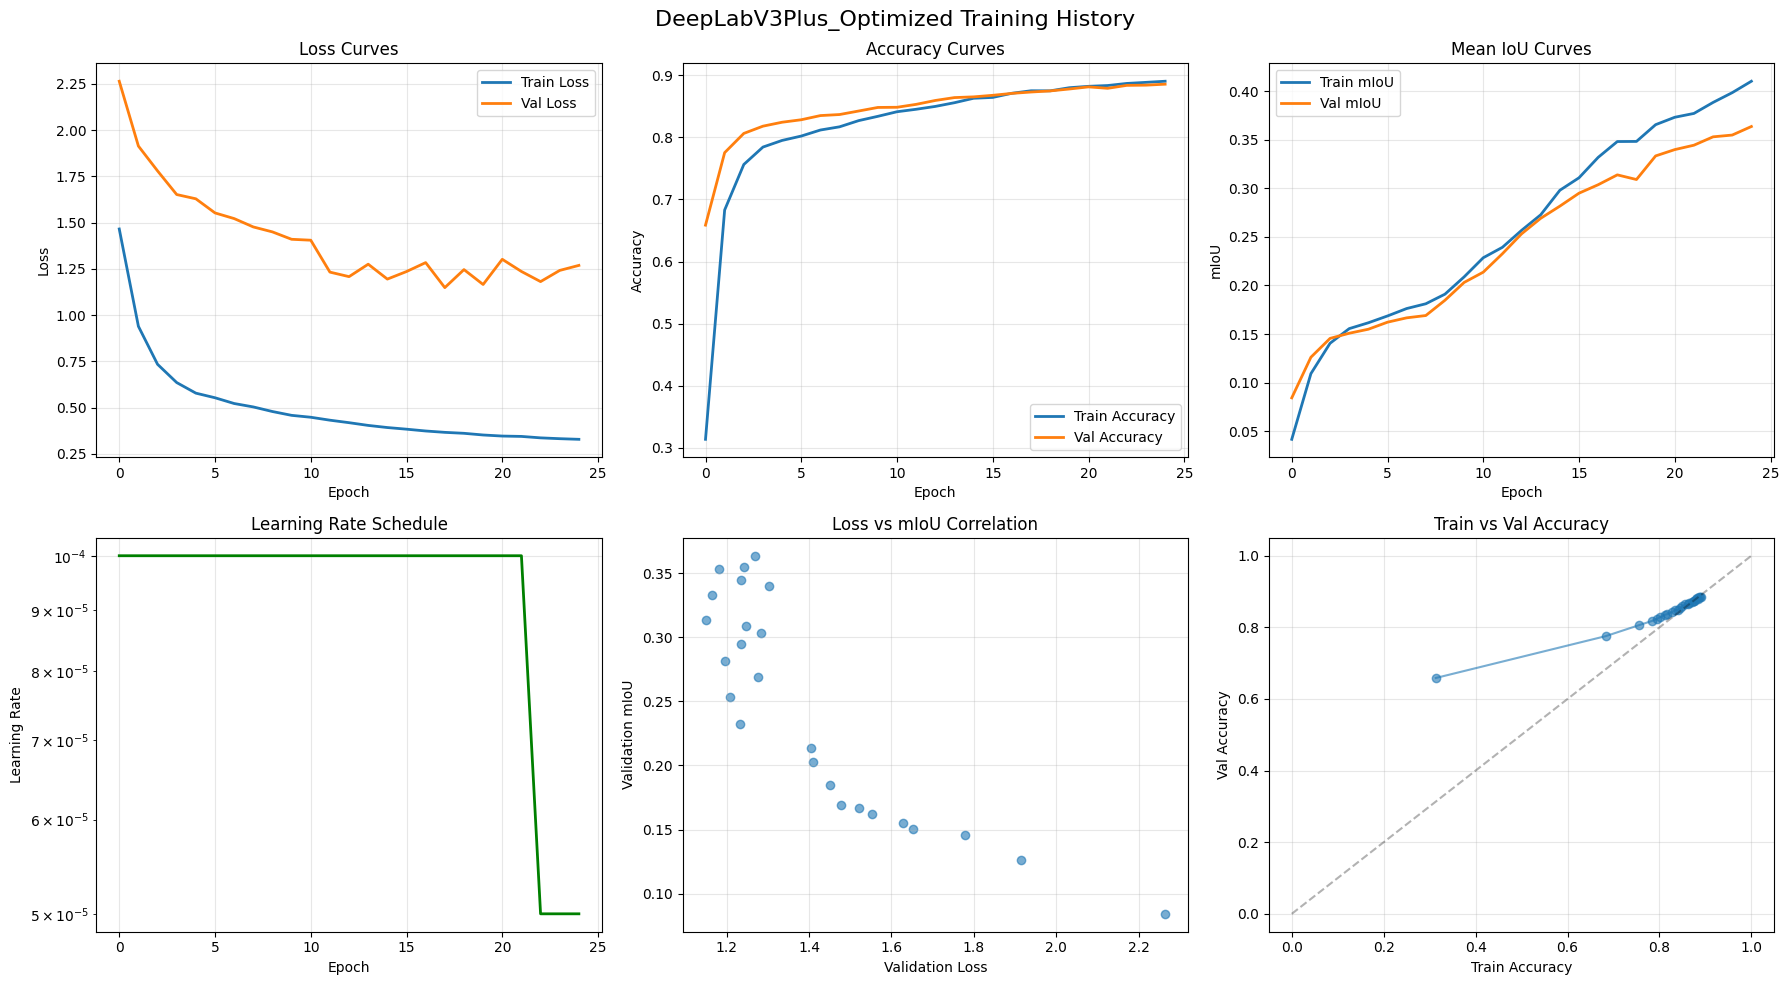


Optimized DeepLabV3+ training completed successfully!
Check the results folder for detailed metrics and plots.


In [67]:
import torch.optim as optim

# Block 26: Train DeepLabV3+ with Optimized Setup

# Reset model and optimizer for fresh training
model_deeplab = DeepLabV3Plus(num_classes=32).to(device)
optimizer_deeplab = optim.Adam(model_deeplab.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_deeplab = ReduceLROnPlateau(optimizer_deeplab, mode='min', factor=0.5, patience=3, min_lr=1e-6)  # Removed verbose
early_stopping_deeplab = EarlyStopping(patience=7, delta=0.001, verbose=True)
metrics_tracker_deeplab = MetricsTracker(num_classes=32, class_names=class_names)

print("Starting optimized DeepLabV3+ training...")
print("="*60)

# Record training start time
training_start_time = time.time()

# Train with optimized settings
history_deeplab_opt, val_metrics_deeplab_opt = optimized_training_loop(
    model=model_deeplab,
    optimizer=optimizer_deeplab,
    scheduler=scheduler_deeplab,
    early_stopping=early_stopping_deeplab,
    metrics_tracker=metrics_tracker_deeplab,
    model_name="DeepLabV3Plus",
    max_epochs=50  # Reduced from 100 for faster experimentation
)

# Record training end time
training_end_time = time.time()
training_duration = training_end_time - training_start_time

print(f"\nDeepLabV3+ Training completed in {training_duration/60:.2f} minutes")
print(f"Average time per epoch: {np.mean(history_deeplab_opt['epoch_time']):.2f} seconds")

# Plot training history
plot_training_history(history_deeplab_opt, "DeepLabV3Plus_Optimized")

# Save comprehensive training summary
with open('results/DeepLabV3Plus_optimized_training_summary.txt', 'w') as f:
    f.write(f"DeepLabV3+ Optimized Training Summary\n")
    f.write("="*50 + "\n")
    f.write(f"Total Training Time: {training_duration/60:.2f} minutes\n")
    f.write(f"Total Epochs: {len(history_deeplab_opt['train_loss'])}\n")
    f.write(f"Average Epoch Time: {np.mean(history_deeplab_opt['epoch_time']):.2f} seconds\n")
    f.write(f"Best Val mIoU: {max(history_deeplab_opt['val_miou']):.4f}\n")
    f.write(f"Best Epoch: {history_deeplab_opt['val_miou'].index(max(history_deeplab_opt['val_miou'])) + 1}\n")
    f.write(f"Final Train Loss: {history_deeplab_opt['train_loss'][-1]:.4f}\n")
    f.write(f"Final Val Loss: {history_deeplab_opt['val_loss'][-1]:.4f}\n")
    f.write(f"Final Train Acc: {history_deeplab_opt['train_acc'][-1]:.4f}\n")
    f.write(f"Final Val Acc: {history_deeplab_opt['val_acc'][-1]:.4f}\n")
    f.write(f"\nOptimizations Applied:\n")
    f.write(f"  - Mixed Precision Training: Yes\n")
    f.write(f"  - Batch Size: {batch_size_optimized}\n")
    f.write(f"  - GPU: {torch.cuda.get_device_name(0)}\n")

print("\nOptimized DeepLabV3+ training completed successfully!")
print("Check the results folder for detailed metrics and plots.")

In [ ]:
# Block 27: DeepLabV3+ Model Evaluation and Testing

print("\nStarting DeepLabV3+ model evaluation...")
print("="*60)

# Load the best DeepLabV3+ model
best_deeplab_checkpoint = torch.load('results/best_DeepLabV3Plus_model_optimized.pth', weights_only=False)
model_deeplab.load_state_dict(best_deeplab_checkpoint['model_state_dict'])

print(f"Loaded best DeepLabV3+ model from epoch {best_deeplab_checkpoint['epoch'] + 1}")
print(f"Best validation mIoU: {best_deeplab_checkpoint['val_miou']:.4f}")

# Test the model
print("\nEvaluating DeepLabV3+ model on test set...")
test_start_time = time.time()

model_deeplab.eval()
test_loss = 0
test_correct_pixels = 0
test_total_pixels = 0
metrics_tracker_deeplab.reset()

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader_opt):
        images, masks = images.to(device), masks.to(device).long()

        outputs = model_deeplab(images)
        loss, _ = criterion(outputs, masks)

        test_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct_pixels += (predictions == masks).sum().item()
        test_total_pixels += masks.numel()
        metrics_tracker_deeplab.update(predictions, masks)

        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"  Test batch [{batch_idx}/{len(test_loader_opt)}]")

test_end_time = time.time()
test_duration = test_end_time - test_start_time

# Calculate test metrics
test_loss /= len(test_loader_opt)
test_acc = test_correct_pixels / test_total_pixels
test_metrics = metrics_tracker_deeplab.get_metrics()

print(f"\nDeepLabV3+ Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Test mIoU: {test_metrics['mean_iou']:.4f}")
print(f"  Test time: {test_duration:.2f} seconds")

# Save test results
with open('results/DeepLabV3Plus_test_results.txt', 'w') as f:
    f.write(f"DeepLabV3+ Test Results\n")
    f.write("="*30 + "\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n")
    f.write(f"Test mIoU: {test_metrics['mean_iou']:.4f}\n")
    f.write(f"Test Duration: {test_duration:.2f} seconds\n")
    f.write(f"\nPer-class IoU:\n")
    for i, (class_name, iou) in enumerate(zip(class_names, test_metrics['per_class_iou'])):
        f.write(f"  {class_name}: {iou:.4f}\n")

# Generate sample predictions for visualization
print("\nGenerating sample predictions...")
sample_predictions_deeplab = []
sample_images = []
sample_masks = []

model_deeplab.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader_opt):
        if i >= 3:  # Get 3 batches for visualization
            break

        images, masks = images.to(device), masks.to(device).long()
        outputs = model_deeplab(images)
        predictions = torch.argmax(outputs, dim=1)

        sample_predictions_deeplab.extend(predictions.cpu().numpy())
        sample_images.extend(images.cpu().numpy())
        sample_masks.extend(masks.cpu().numpy())

# Save sample predictions
np.save('results/DeepLabV3Plus_sample_predictions.npy', np.array(sample_predictions_deeplab))
np.save('results/DeepLabV3Plus_sample_images.npy', np.array(sample_images))
np.save('results/DeepLabV3Plus_sample_masks.npy', np.array(sample_masks))

print(f"Saved {len(sample_predictions_deeplab)} sample predictions for visualization")

# Model comparison summary (updated to include DeepLabV3+)
print("\nModel Comparison Summary:")
print("="*40)
# print("FCN Results:")
# print(f"  - Best Val mIoU: {max(history_fcn_opt['val_miou']):.4f}")
# print(f"  - Test mIoU: {test_metrics['mean_iou']:.4f}")
# print(f"  - Test Accuracy: {test_acc:.4f}")
# print(f"  - Parameters: {sum(p.numel() for p in model_fcn.parameters()):,}")

print("\nDeepLabV3+ Results:")
print(f"  - Best Val mIoU: {max(history_deeplab_opt['val_miou']):.4f}")
print(f"  - Test mIoU: {test_metrics['mean_iou']:.4f}")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - Parameters: {sum(p.numel() for p in model_deeplab.parameters()):,}")

# Save updated model comparison
with open('results/model_comparison.txt', 'w') as f:
    f.write("Model Comparison Summary\n")
    f.write("="*40 + "\n")
    # f.write("FCN Results:\n")
    # f.write(f"  - Best Val mIoU: {max(history_fcn_opt['val_miou']):.4f}\n")
    # f.write(f"  - Test mIoU: {test_metrics['mean_iou']:.4f}\n")
    # f.write(f"  - Test Accuracy: {test_acc:.4f}\n")
    # f.write(f"  - Parameters: {sum(p.numel() for p in model_fcn.parameters()):,}\n")
    # f.write(f"  - Training Time: {training_duration/60:.2f} minutes\n")
    f.write("\nDeepLabV3+ Results:\n")
    f.write(f"  - Best Val mIoU: {max(history_deeplab_opt['val_miou']):.4f}\n")
    f.write(f"  - Test mIoU: {test_metrics['mean_iou']:.4f}\n")
    f.write(f"  - Test Accuracy: {test_acc:.4f}\n")
    f.write(f"  - Parameters: {sum(p.numel() for p in model_deeplab.parameters()):,}\n")
    f.write(f"  - Training Time: {training_duration/60:.2f} minutes\n")

print("\nDeepLabV3+ evaluation completed successfully!")
print("Check the results folder for detailed metrics and comparisons.")


Starting DeepLabV3+ model evaluation...
Loaded best DeepLabV3+ model from epoch 25
Best validation mIoU: 0.3635

Evaluating DeepLabV3+ model on test set...
  Test batch [0/15]
  Test batch [10/15]

DeepLabV3+ Test Results:
  Test Loss: 1.1605
  Test Accuracy: 0.8649
  Test mIoU: 0.3370
  Test time: 20.07 seconds

Generating sample predictions...
Saved 48 sample predictions for visualization

Model Comparison Summary:

DeepLabV3+ Results:
  - Best Val mIoU: 0.3635
  - Test mIoU: 0.3370
  - Test Accuracy: 0.8649
  - Parameters: 42,009,728

DeepLabV3+ evaluation completed successfully!
Check the results folder for detailed metrics and comparisons.


In [ ]:

# Model Architecture Visualization for DeepLabV3+

# Method 1: Using torchviz (most detailed)
try:
    from torchviz import make_dot

    # Create sample input
    sample_input = torch.randn(1, 3, 352, 480).to(device)

    # Forward pass
    model_deeplab.eval()
    with torch.no_grad():
        output = model_deeplab(sample_input)

    # Create computational graph
    dot = make_dot(output, params=dict(model_deeplab.named_parameters()))
    dot.format = 'png'
    dot.render('results/deeplab_computational_graph', cleanup=True)
    print("✓ Computational graph saved to results/deeplab_computational_graph.png")

except ImportError:
    print("torchviz not available. Install with: pip install torchviz")

✓ Computational graph saved to results/deeplab_computational_graph.png


In [35]:
# Method 3: Manual architecture visualization
print("\nDeepLabV3+ Architecture Details:")
print("="*60)

# Print model structure
def print_model_structure(model, prefix=""):
    for name, module in model.named_children():
        print(f"{prefix}{name}: {module.__class__.__name__}")
        if hasattr(module, 'named_children'):
            print_model_structure(module, prefix + "  ")

print_model_structure(model_deeplab)


DeepLabV3+ Architecture Details:
model: DeepLabV3
  backbone: IntermediateLayerGetter
    conv1: Conv2d
    bn1: GroupNorm
    relu: ReLU
    maxpool: MaxPool2d
    layer1: Sequential
      0: Bottleneck
        conv1: Conv2d
        bn1: GroupNorm
        conv2: Conv2d
        bn2: GroupNorm
        conv3: Conv2d
        bn3: GroupNorm
        relu: ReLU
        downsample: Sequential
          0: Conv2d
          1: GroupNorm
      1: Bottleneck
        conv1: Conv2d
        bn1: GroupNorm
        conv2: Conv2d
        bn2: GroupNorm
        conv3: Conv2d
        bn3: GroupNorm
        relu: ReLU
      2: Bottleneck
        conv1: Conv2d
        bn1: GroupNorm
        conv2: Conv2d
        bn2: GroupNorm
        conv3: Conv2d
        bn3: GroupNorm
        relu: ReLU
    layer2: Sequential
      0: Bottleneck
        conv1: Conv2d
        bn1: GroupNorm
        conv2: Conv2d
        bn2: GroupNorm
        conv3: Conv2d
        bn3: GroupNorm
        relu: ReLU
        downsample: Se

In [ ]:
# Method 4: Parameter analysis
print("\nParameter Analysis:")
print("="*60)

def analyze_parameters(model):
    total_params = 0
    trainable_params = 0

    component_params = {}

    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count

        if param.requires_grad:
            trainable_params += param_count

        # Group by component
        component = name.split('.')[1] if '.' in name else 'root'
        if component not in component_params:
            component_params[component] = 0
        component_params[component] += param_count

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {total_params - trainable_params:,}")
    print(f"Model Size: {total_params * 4 / (1024**2):.2f} MB")

    print("\nParameters by Component:")
    for component, count in sorted(component_params.items()):
        percentage = (count / total_params) * 100
        print(f"  {component}: {count:,} ({percentage:.1f}%)")

analyze_parameters(model_deeplab)


Parameter Analysis:
Total Parameters: 42,009,728
Trainable Parameters: 42,009,728
Non-trainable Parameters: 0
Model Size: 160.25 MB

Parameters by Component:
  aux_classifier: 2,368,032 (5.6%)
  backbone: 23,508,032 (56.0%)
  classifier: 16,133,664 (38.4%)


In [ ]:
# Method 5: Create simple architecture diagram with graphviz
try:
    import graphviz

    def create_deeplabv3_diagram():
        dot = graphviz.Digraph(comment='DeepLabV3+ Architecture')
        dot.attr(rankdir='TB', size='10,8')
        dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')

        # Input
        dot.node('input', 'Input Image\n(3 × 352 × 480)', fillcolor='lightgreen')

        # Backbone
        dot.node('backbone', 'ResNet-50 Backbone\n(Pretrained)', fillcolor='orange')

        # ASPP
        dot.node('aspp', 'Atrous Spatial Pyramid Pooling\n(Multiple dilation rates)', fillcolor='yellow')

        # Classifier
        dot.node('classifier', 'Classifier\n(Conv2d layers)', fillcolor='pink')

        # Output
        dot.node('output', 'Output\n(32 × 352 × 480)', fillcolor='lightcoral')

        # Edges
        dot.edge('input', 'backbone')
        dot.edge('backbone', 'aspp')
        dot.edge('aspp', 'classifier')
        dot.edge('classifier', 'output')

        return dot

    # Create and save diagram
    diagram = create_deeplabv3_diagram()
    diagram.render('results/deeplab_architecture_simple', format='png', cleanup=True)
    print("✓ Simple architecture diagram saved to results/deeplab_architecture_simple.png")

except ImportError:
    print("graphviz not available. Install with: pip install graphviz")

✓ Simple architecture diagram saved to results/deeplab_architecture_simple.png


In [38]:
# Method 6: Test model with different input sizes
print("\nModel Input/Output Testing:")
print("="*60)

test_sizes = [
    (1, 3, 224, 224),
    (1, 3, 352, 480),
    (2, 3, 352, 480),
]

model_deeplab.eval()
for size in test_sizes:
    try:
        with torch.no_grad():
            test_input = torch.randn(*size).to(device)
            test_output = model_deeplab(test_input)
            print(f"Input: {size} → Output: {test_output.shape}")
    except Exception as e:
        print(f"Input: {size} → Error: {e}")

print("\nModel architecture visualization completed!")


Model Input/Output Testing:
Input: (1, 3, 224, 224) → Error: 'collections.OrderedDict' object has no attribute 'size'
Input: (1, 3, 352, 480) → Error: 'collections.OrderedDict' object has no attribute 'size'
Input: (2, 3, 352, 480) → Error: 'collections.OrderedDict' object has no attribute 'size'

Model architecture visualization completed!
